# Bone X-Ray abnormality detection

**Problem**

Given a study containing X-Ray images build a deep learning model that decides if the study is normal or abnormal. We use at least two different architectures, one using a CNN we have created from scratch and one using a pre-trained popular CNN (e.g., ResNet).
We use the MURA dataset to train and evaluate your models. More information about the task 
and the dataset can be found at https://stanfordmlgroup.github.io/competitions/mura/

In [ ]:
# from google.colab import drive

# drive.mount('/content/drive')

# %cd '/content/drive/MyDrive/DeepLearning/HW02'

# Libraries

In [1]:
!nvidia-smi

Wed Jul 21 20:25:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#https://pypi.org/project/keras-adabound/
!pip install keras-adabound

  Created wheel for keras-adabound: filename=keras_adabound-0.6.0-py3-none-any.whl size=6608 sha256=9be522e0202079317982d92f08882033ee0a944221f0cf4fd9f24ed85efe31eb
  Stored in directory: /root/.cache/pip/wheels/3e/bf/39/3d95847ef12aa58c15a6cc7a20f4f21ea39fcd52793e1beea0
Successfully built keras-adabound


In [3]:
!pip install tensorflow_addons

     |████████████████████████████████| 679 kB 34.9 MB/s 


In [4]:
import os
import random

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from enum import Enum

import cv2

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
import gc

from tensorflow.keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#optimizers
from tensorflow.keras.optimizers import SGD, Adam
from keras_adabound import AdaBound

from tensorflow.keras.losses import BinaryCrossentropy

# Layers to be used for building our model
from tensorflow.keras.layers import Input, Conv2D,BatchNormalization
from tensorflow.keras.layers import Activation,SpatialDropout2D,AvgPool2D
from tensorflow.keras.layers import MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D,Flatten,Dropout,Dense

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential

from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from sklearn.metrics import cohen_kappa_score, accuracy_score

#Pretrained models
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import DenseNet121,DenseNet169,DenseNet201

#For Ensemblers
from tensorflow.keras.models import load_model
from numpy import dstack
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import VotingClassifier

In [5]:
# define seed number to have reproducible experiments.
seed = 3352024

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Load data

This data comes as split dataset (training & validation in separate directories). Each data categories such as training & validation has sub-directories (pls see below).


```

└─train {data category}
│   └───XR_ELBOW {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {radiographs}
│       │               └───image2.png 
│       │               └───image3.png 
                        └───...
   ...
   

└─valid {data category}
│   └───XR_HUMERUS {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {radiographs}
│       │               └───image2.png 
                        └───...
```

## Download dataset

In [6]:
!wget 'https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip'

--2021-07-21 20:26:09--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘MURA-v1.1.zip’

MURA-v1.1.zip       100%[===================>]   3.15G  3.78MB/s    in 4m 27s  

2021-07-21 20:30:36 (12.1 MB/s) - ‘MURA-v1.1.zip’ saved [3380245855/3380245855]



In [7]:
!unzip MURA-v1.1.zip

Streaming output truncated to the last 5000 lines.
   creating: MURA-v1.1/train/XR_SHOULDER/patient01061/
   creating: MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image1.png  
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image3.png  
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image2.png  
   creating: MURA-v1.1/train/XR_SHOULDER/patient01016/
   creating: MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image1.png  
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image3.png  
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image2.png  
   creating: MURA-v1.1/train/XR_SHOULDER/patient01182/
   creating: MURA-v1.1/train/XR_SHOULDER/patient01182/study1_positive/
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01182/study1_positive/ima

## First way to load dataset

**Load dataset**

In [8]:
def load_path(path):
    
    '''
    load MURA dataset
    '''
    
    dataset = [] 

    for body in os.listdir(path):
        body_part = body

    #     print(os.listdir(path_p))
        path_p = path+'/'+str(body)

        for id_p in os.listdir(path_p):

            patient_id = id_p

            path_id = path_p+'/'+str(id_p)
    #         print(os.listdir(path_id))

            for lab in os.listdir(path_id):

                #positive Label is 1, otherwise 0
                #directory file patient11880\\study1_negative\\image3.png
                if lab.split('_')[-1]=='positive': 
                    label = 1 
                elif lab.split('_')[-1]=='negative':
                    label= 0

                path_l = path_id+'/'+str(lab)
    #             print(os.listdir(path_l))   
    #             print('----')

                for img in os.listdir(path_l):
    #                   print(img)
                    img_path = path_l + '/' + str(img)

                    dataset.append(
                        {
                            'body_part': body_part,
                            'patient_id': patient_id,
                            'label': label,
                            'img_path': img_path
                        }
                    )
    return dataset

In [9]:
path = 'MURA-v1.1/train'
os.listdir(path)

['XR_SHOULDER',
 'XR_HUMERUS',
 'XR_WRIST',
 'XR_ELBOW',
 'XR_FINGER',
 'XR_HAND',
 'XR_FOREARM']

**Train set**

In [10]:
dataset = load_path(path)
df_train = pd.DataFrame(dataset)
df_train 

,body_part,patient_id,label,img_path
0,XR_SHOULDER,patient00864,1,MURA-v1.1/train/XR_SHOULDER/patient00864/study...
1,XR_SHOULDER,patient00258,1,MURA-v1.1/train/XR_SHOULDER/patient00258/study...
2,XR_SHOULDER,patient00258,1,MURA-v1.1/train/XR_SHOULDER/patient00258/study...
3,XR_SHOULDER,patient00258,1,MURA-v1.1/train/XR_SHOULDER/patient00258/study...
4,XR_SHOULDER,patient00258,1,MURA-v1.1/train/XR_SHOULDER/patient00258/study...
...,...,...,...,...
36807,XR_FOREARM,patient00222,0,MURA-v1.1/train/XR_FOREARM/patient00222/study1...
36808,XR_FOREARM,patient09470,0,MURA-v1.1/train/XR_FOREARM/patient09470/study1...
36809,XR_FOREARM,patient08079,0,MURA-v1.1/train/XR_FOREARM/patient08079/study1...
36810,XR_FOREARM,patient09576,0,MURA-v1.1/train/XR_FOREARM/patient09576/study1...


In [11]:
df_train.img_path[3]

'MURA-v1.1/train/XR_SHOULDER/patient00258/study1_positive/image4.png'

In [12]:
df_train.img_path[4]

'MURA-v1.1/train/XR_SHOULDER/patient00258/study1_positive/image1.png'

**Test set**

In [13]:
dataset_test = load_path(path = 'MURA-v1.1/valid')
df_test = pd.DataFrame(dataset_test)
df_test

,body_part,patient_id,label,img_path
0,XR_SHOULDER,patient11709,0,MURA-v1.1/valid/XR_SHOULDER/patient11709/study...
1,XR_SHOULDER,patient11709,0,MURA-v1.1/valid/XR_SHOULDER/patient11709/study...
2,XR_SHOULDER,patient11709,0,MURA-v1.1/valid/XR_SHOULDER/patient11709/study...
3,XR_SHOULDER,patient11709,1,MURA-v1.1/valid/XR_SHOULDER/patient11709/study...
4,XR_SHOULDER,patient11709,1,MURA-v1.1/valid/XR_SHOULDER/patient11709/study...
...,...,...,...,...
3192,XR_FOREARM,patient11454,0,MURA-v1.1/valid/XR_FOREARM/patient11454/study1...
3193,XR_FOREARM,patient11308,1,MURA-v1.1/valid/XR_FOREARM/patient11308/study1...
3194,XR_FOREARM,patient11308,1,MURA-v1.1/valid/XR_FOREARM/patient11308/study1...
3195,XR_FOREARM,patient11220,1,MURA-v1.1/valid/XR_FOREARM/patient11220/study1...


## Alternative way to load dataset

inspired from https://www.kaggle.com/hasnaatawfik/mura-classification?fbclid=IwAR0uW8oNPMdcBMUe6keuRUmCNPp57rOCbH6Cg8gMB6lqNpwW2bW36XjMRxw

- image_path : the absolute path to image
- label : positive/negative the case classification
- category : the part of body in the image (XR_WRIST,XR_SHOULDER,XR_HAND,XR_FINGER,XR_ELBOW,XR_FOREARM,XR_HUMERUS)
- patientId :the study subfolder name withch refer to specific patient

We explore in paragraph "Explore alternative way", why we use two ways for load dataset

**Training set**

In [14]:
#csv files path
path = 'MURA-v1.1'
#csv files names
train_image_paths_csv = "train_image_paths.csv"

In [15]:
train_images_paths = pd.read_csv(os.path.join(path,train_image_paths_csv),dtype=str,header=None)
train_images_paths.columns = ['image_path']

In [16]:
train_images_paths['label'] = train_images_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')

train_images_paths['category']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[2])  
train_images_paths['patientId']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
train_images_paths.head()

,image_path,label,category,patientId
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002


In [17]:
total_number_of_training_images = np.shape(train_images_paths)[0]
print("total number of images:",total_number_of_training_images )

total number of images: 36808


**Test set**

In [18]:
#csv files path
path = 'MURA-v1.1'
#csv files names
valid_image_paths_csv = "valid_image_paths.csv"
valid_data_paths = pd.read_csv(os.path.join(path,valid_image_paths_csv),dtype=str,header=None)
valid_data_paths.columns = ['image_path']

In [19]:
valid_data_paths['label'] = valid_data_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
valid_data_paths['category']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[2])  
valid_data_paths['dir'] =  valid_data_paths['image_path'].apply(lambda x: x.split('/')[1])
valid_data_paths['patientId']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
valid_data_paths.head()

,image_path,label,category,dir,patientId
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive,XR_WRIST,valid,11186


In [20]:
total_number_of_valid_images = np.shape(valid_data_paths)[0]
print("total number of images:",total_number_of_valid_images )

total number of images: 3197


## Preprocessing

Like a One hot encode

In [21]:
train_images_paths['label_index']= train_images_paths.label

In [22]:
train_images_paths.label_index.replace('positive', 1, inplace=True)
train_images_paths.label_index.replace('negative', 0, inplace=True)

In [23]:
train_images_paths.head(3)

,image_path,label,category,patientId,label_index
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1


In [24]:
train_images_paths.tail(3)

,image_path,label,category,patientId,label_index
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,negative,XR_HAND,11184,0
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,negative,XR_HAND,11184,0
36807,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,negative,XR_HAND,11184,0


In [25]:
valid_data_paths['label_index']= valid_data_paths.label
valid_data_paths.label_index.replace('positive', 1, inplace=True)
valid_data_paths.label_index.replace('negative', 0, inplace=True)
valid_data_paths.head(3)

,image_path,label,category,dir,patientId,label_index
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1


# Data Exploratory Analysis

## Explore dataset

In [ ]:
print('We have '+str(len(df_train))+' train images from all body parts')

We have 36812 train images from all body parts


In [ ]:
print('We have Bone X-Ray from: ')
path = 'MURA-v1.1/train'
print(*os.listdir(path), sep = "\n")

We have Bone X-Ray from: 
XR_WRIST
XR_HAND
XR_FINGER
XR_FOREARM
XR_SHOULDER
XR_HUMERUS
XR_ELBOW


## Explore body parts of dataset

In [ ]:
grouped = df_train.groupby(df_train.body_part)
df_XR_ELBOW = grouped.get_group("XR_ELBOW")
df_XR_ELBOW.head(4)

,body_part,patient_id,label,img_path
31881,XR_ELBOW,patient03453,0,MURA-v1.1/train/XR_ELBOW/patient03453/study1_n...
31882,XR_ELBOW,patient03453,0,MURA-v1.1/train/XR_ELBOW/patient03453/study1_n...
31883,XR_ELBOW,patient03453,0,MURA-v1.1/train/XR_ELBOW/patient03453/study1_n...
31884,XR_ELBOW,patient05354,1,MURA-v1.1/train/XR_ELBOW/patient05354/study1_p...


In [ ]:
print("Number of training XR_ELBOW: ",len(df_XR_ELBOW))

Number of training XR_ELBOW:  4931


In [ ]:
training_data_distr = []

In [ ]:
def count_distrib(df_body, body_name):
    '''
    count and print the number of positive,negative and total X-Ray for a part of body
    
    df_body : the dataframe of the part of the body that we will calculate
    body_name: a string name of the part of body that we focus on it
    
    '''
    grouped = df_body.groupby(df_body.label)
    
    pos = len(grouped.get_group(1))
    
    print('We have ' +str(pos)+ ' positive '+ body_name)
    
    print('vs')
    
    neg = len(grouped.get_group(0))
    print( 'We have ' +str(neg)+ ' negative '+ body_name)
    
    total = len(df_body)
    
    return body_name, pos, neg, total

In [ ]:
body_name, pos, neg, total = count_distrib(df_XR_ELBOW, 'XR_ELBOW')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 2006 positive XR_ELBOW
vs
We have 2925 negative XR_ELBOW


In [ ]:
df_XR_FINGER = grouped.get_group("XR_FINGER")
df_XR_FINGER.head(4)

,body_part,patient_id,label,img_path
15299,XR_FINGER,patient04761,0,MURA-v1.1/train/XR_FINGER/patient04761/study1_...
15300,XR_FINGER,patient03453,1,MURA-v1.1/train/XR_FINGER/patient03453/study1_...
15301,XR_FINGER,patient03453,1,MURA-v1.1/train/XR_FINGER/patient03453/study1_...
15302,XR_FINGER,patient03453,1,MURA-v1.1/train/XR_FINGER/patient03453/study1_...


In [ ]:
print("Number of training XR_FINGER: ",len(df_XR_FINGER))

Number of training XR_FINGER:  5106


In [ ]:
body_name, pos, neg, total = count_distrib(df_XR_FINGER, 'XR_FINGER')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 1968 positive XR_FINGER
vs
We have 3138 negative XR_FINGER


In [ ]:
df_XR_FOREARM = grouped.get_group("XR_FOREARM")
df_XR_FOREARM.head(4)

,body_part,patient_id,label,img_path
20405,XR_FOREARM,patient09449,0,MURA-v1.1/train/XR_FOREARM/patient09449/study1...
20406,XR_FOREARM,patient09449,0,MURA-v1.1/train/XR_FOREARM/patient09449/study1...
20407,XR_FOREARM,patient09628,0,MURA-v1.1/train/XR_FOREARM/patient09628/study1...
20408,XR_FOREARM,patient09628,0,MURA-v1.1/train/XR_FOREARM/patient09628/study1...


In [ ]:
print("Number of training XR_FOREARM: ",len(df_XR_FOREARM))

Number of training XR_FOREARM:  1825


In [ ]:
body_name, pos, neg, total = count_distrib(df_XR_FOREARM, 'XR_FOREARM')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 661 positive XR_FOREARM
vs
We have 1164 negative XR_FOREARM


In [ ]:
df_XR_HAND = grouped.get_group("XR_HAND")
df_XR_HAND.head(4)

,body_part,patient_id,label,img_path
9756,XR_HAND,patient10449,0,MURA-v1.1/train/XR_HAND/patient10449/study1_ne...
9757,XR_HAND,patient10449,0,MURA-v1.1/train/XR_HAND/patient10449/study1_ne...
9758,XR_HAND,patient10449,0,MURA-v1.1/train/XR_HAND/patient10449/study1_ne...
9759,XR_HAND,patient01546,0,MURA-v1.1/train/XR_HAND/patient01546/study1_ne...


In [ ]:
print("Number of training XR_HAND: ",len(df_XR_HAND))

Number of training XR_HAND:  5543


In [ ]:
body_name, pos, neg, total = count_distrib(df_XR_HAND, 'XR_HAND')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 1484 positive XR_HAND
vs
We have 4059 negative XR_HAND


In [ ]:
df_XR_HUMERUS = grouped.get_group("XR_HUMERUS")
df_XR_HUMERUS.head(4)

,body_part,patient_id,label,img_path
30609,XR_HUMERUS,patient03197,0,MURA-v1.1/train/XR_HUMERUS/patient03197/study1...
30610,XR_HUMERUS,patient02771,1,MURA-v1.1/train/XR_HUMERUS/patient02771/study1...
30611,XR_HUMERUS,patient02771,1,MURA-v1.1/train/XR_HUMERUS/patient02771/study1...
30612,XR_HUMERUS,patient03021,0,MURA-v1.1/train/XR_HUMERUS/patient03021/study1...


In [ ]:
print("Number of training XR_HUMERUS: ",len(df_XR_HUMERUS))

Number of training XR_HUMERUS:  1272


In [ ]:
body_name, pos, neg, total = count_distrib(df_XR_HUMERUS, 'XR_HUMERUS')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 599 positive XR_HUMERUS
vs
We have 673 negative XR_HUMERUS


In [ ]:
df_XR_SHOULDER = grouped.get_group("XR_SHOULDER")
df_XR_SHOULDER.head(4)

,body_part,patient_id,label,img_path
22230,XR_SHOULDER,patient01546,0,MURA-v1.1/train/XR_SHOULDER/patient01546/study...
22231,XR_SHOULDER,patient01546,0,MURA-v1.1/train/XR_SHOULDER/patient01546/study...
22232,XR_SHOULDER,patient01546,0,MURA-v1.1/train/XR_SHOULDER/patient01546/study...
22233,XR_SHOULDER,patient01546,0,MURA-v1.1/train/XR_SHOULDER/patient01546/study...


In [ ]:
print("Number of training XR_SHOULDER: ",len(df_XR_SHOULDER))

Number of training XR_SHOULDER:  8379


In [ ]:
body_name, pos, neg, total = count_distrib(df_XR_SHOULDER, 'XR_SHOULDER')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 4168 positive XR_SHOULDER
vs
We have 4211 negative XR_SHOULDER


In [ ]:
df_XR_WRIST = grouped.get_group("XR_WRIST")
df_XR_WRIST.head(4)

,body_part,patient_id,label,img_path
0,XR_WRIST,patient03453,0,MURA-v1.1/train/XR_WRIST/patient03453/study1_n...
1,XR_WRIST,patient03453,0,MURA-v1.1/train/XR_WRIST/patient03453/study1_n...
2,XR_WRIST,patient03453,0,MURA-v1.1/train/XR_WRIST/patient03453/study1_n...
3,XR_WRIST,patient01546,0,MURA-v1.1/train/XR_WRIST/patient01546/study1_n...


In [ ]:
print("Number of training XR_WRIST: ",len(df_XR_WRIST))

Number of training XR_WRIST:  9756


In [ ]:
body_name, pos, neg, total = count_distrib(df_XR_WRIST, 'XR_WRIST')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 3987 positive XR_WRIST
vs
We have 5769 negative XR_WRIST


## Explore with plots

In [ ]:
training_data_distr = pd.DataFrame(training_data_distr)

In [ ]:
training_data_distr['percentage'] = round(100 * training_data_distr['total'] / len(df_train.body_part), 2)

In [ ]:
print('Training Data Distribution')
training_data_distr

Training Data Distribution


,body_part,positive,negative,total,percentage
0,XR_ELBOW,2006,2925,4931,13.40
1,XR_FINGER,1968,3138,5106,13.87
2,XR_FOREARM,661,1164,1825,4.96
3,XR_HAND,1484,4059,5543,15.06
4,XR_HUMERUS,599,673,1272,3.46
5,XR_SHOULDER,4168,4211,8379,22.76
6,XR_WRIST,3987,5769,9756,26.50


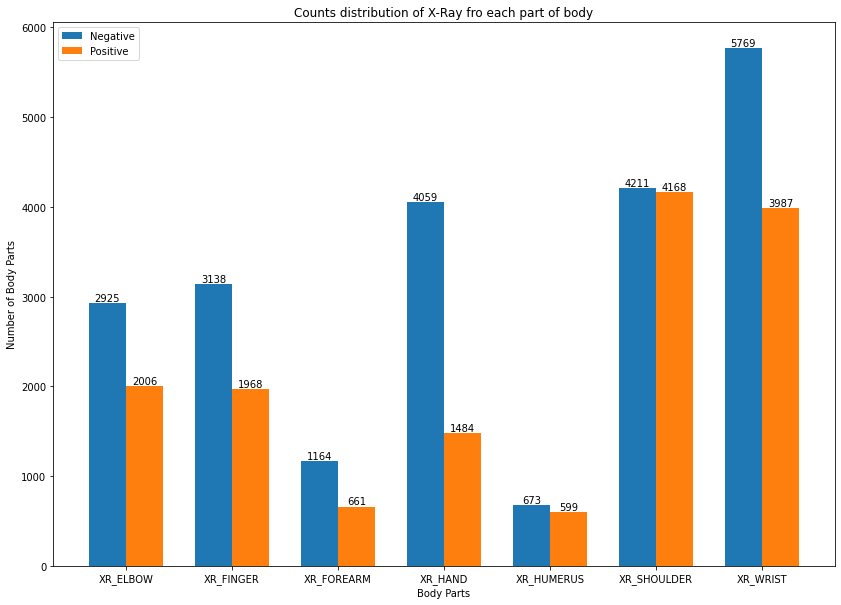

In [ ]:
labels = training_data_distr['body_part']
negative = training_data_distr['negative']
positive = training_data_distr['positive']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig = plt.figure(figsize=(14, 10))

ax = fig.subplots()
rects1 = ax.bar(x - width/2, negative, width, label='Negative')
rects2 = ax.bar(x + width/2, positive, width, label='Positive')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Body Parts')
ax.set_xlabel('Body Parts')
ax.set_title('Counts distribution of X-Ray fro each part of body')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.00*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

We observe that only the XR-Shoulder has balance data and XR-Wrist has the most of data for negative X-Ray. 

Moreover, we understand that we do not have same number of data of each category, so we may be difficult to train the model in some categories like XR-Humerus. Thus, it is vital we use the feature category in our model. 

Furthermore, if we split train set to validation and develop, it is better we take a part of each part of body seperatively (or suffle the data), to maintain the distribution of each category.


**Train set**

In [ ]:
grouped = df_train.groupby(df_train.label)
    
pos = len(grouped.get_group(1))
neg = len(grouped.get_group(0))

In [ ]:
print("Number of positives:",pos)
print("Number of negatives:",neg)

Number of positives: 14873
Number of negatives: 21939


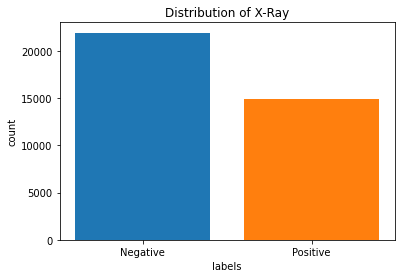

In [ ]:
# the data you want to plot
categories = ["Negative"]
values     = [ neg]

categories2 = ["Positive"]
values2     = [  pos]

plt.bar(categories, values)
plt.bar(categories2, values2)

# Add title and axis names
plt.title('Distribution of X-Ray')
plt.xlabel('labels')
plt.ylabel('count')


plt.show()

The dataset of trainnig data is unbalance with more negative images.

So,we may need to create augment data for the positive category to be balance, if the model are bias.

**Test set**

In [ ]:
grouped = valid_data_paths.groupby(valid_data_paths.label)
    
pos = len(grouped.get_group('positive'))
neg = len(grouped.get_group('negative'))

In [ ]:
print("Number of positives:",pos)
print("Number of negatives:",neg)

Number of positives: 1530
Number of negatives: 1667


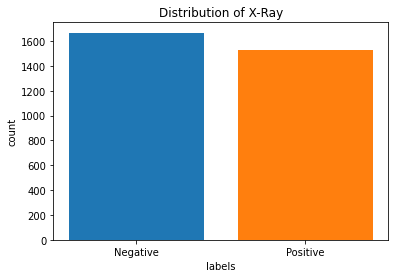

In [ ]:
# the data you want to plot
categories = ["Negative"]
values     = [ neg]

categories2 = ["Positive"]
values2     = [  pos]

plt.bar(categories, values)
plt.bar(categories2, values2)

# Add title and axis names
plt.title('Distribution of X-Ray')
plt.xlabel('labels')
plt.ylabel('count')


plt.show()

The dataset of test data is far more balance than train data.


## Explore alternative way

**Summary of alternative way**

In [ ]:
#https://www.kaggle.com/hasnaatawfik/mura-classification?fbclid=IwAR0uW8oNPMdcBMUe6keuRUmCNPp57rOCbH6Cg8gMB6lqNpwW2bW36XjMRxw
total_number_of_training_images = np.shape(train_images_paths)[0]
print ("\n\nnumber of null values in:\n", train_images_paths.isnull().sum())

print("\n\nnumber of training images:",np.shape(train_images_paths['image_path'])[0])

#values counts table 
categories_counts = pd.DataFrame(train_images_paths['category'].value_counts())
print ('\n\ncategories:\n',categories_counts )
print('\n\nnumber of patients:',train_images_paths['patientId'].nunique())
print('\n\nnumber of labels:',train_images_paths['label'].nunique())
print ('\n\npositive XR:',len(train_images_paths[train_images_paths['label']=='positive']))
print ('\n\nnegative XR:',len(train_images_paths[train_images_paths['label']=='negative']))



number of null values in:
 image_path     0
label          0
category       0
patientId      0
label_index    0
dtype: int64


number of training images: 36808


categories:
              category
XR_WRIST         9752
XR_SHOULDER      8379
XR_HAND          5543
XR_FINGER        5106
XR_ELBOW         4931
XR_FOREARM       1825
XR_HUMERUS       1272


number of patients: 11184


number of labels: 2


positive XR: 14873


negative XR: 21935


**Compare the two ways of data load**

In [ ]:
print("Number of training images in first way:", len(df_train["img_path"]))
print("vs")
print("Number of training images in alternative way:",np.shape(train_images_paths['image_path'])[0])

Number of training images in first way: 36812
vs
Number of training images in alternative way: 36808


In [ ]:
print("Number of body parts training images in first way: ")
categories_counts = pd.DataFrame(df_train['body_part'].value_counts())
print ('\n\ncategories:\n',categories_counts )

print('\n\n VS \n')

print("Number of body parts training images in alternative way: ")
categories_counts = pd.DataFrame(train_images_paths['category'].value_counts())
print ('\n\ncategories:\n',categories_counts ) 

Number of body parts training images in first way: 


categories:
              body_part
XR_WRIST          9756
XR_SHOULDER       8379
XR_HAND           5543
XR_FINGER         5106
XR_ELBOW          4931
XR_FOREARM        1825
XR_HUMERUS        1272


 VS 

Number of body parts training images in alternative way: 


categories:
              category
XR_WRIST         9752
XR_SHOULDER      8379
XR_HAND          5543
XR_FINGER        5106
XR_ELBOW         4931
XR_FOREARM       1825
XR_HUMERUS       1272


We observe that the first way, which load data following the paths, has 4 images in XR_WRIST more than the alternative way which load data through the train_image_paths.csv. Τhey do not have a large deviation, so we select the alternative way. 

(Extra: we observe that when we retrieve images with image_loader, ignored 4 images, so we understant that something is wrong, and there is purpose that alternative way with train_image_paths.csv ingored 4 examples)

## Explore images

### Preprocessing some Images 

In [ ]:
##### !!! See AGAIN !!! #####

In [ ]:
#im_size = 512

#im_size = 224

im_size = 256

In [ ]:
def random_rotation_flip(image,size = 256):
    if random.randint(0,1):
        image = cv2.flip(image,1) # 1-->horizontal flip 0-->Vertical flip -1-->Horizontal and vertical

    if random.randint(0,1):
            angle = random.randint(-30,30)
            M = cv2.getRotationMatrix2D((size/2,size/2),angle,1)
            #The third parameter: the size of the transformed image
            image = cv2.warpAffine(image,M,(size,size))
    return image

In [ ]:
#https://github.com/vraul92/Humerus-Bone-Fracture-Detection/blob/master/train__humerus_fracture_detection_keras_model.ipynb
#https://github.com/ag-piyush/Bone-Fracture-Detection---MURA/blob/cfd68b53dd39bd81aa893b4b7cc38c296920f37e/data_loader.py#L52
def image_loader(Path, size = 224):
    
    Images = []
    
    for path in tqdm(Path):
        try:
            image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image,(size,size))
            image = random_rotation_flip(image,size)
            Images.append(image)
        
        except Exception as e:
            print(str(e))
            
    Images = np.asarray(Images).astype('float32')

    #normalization
    mean = np.mean(Images)
    std = np.std(Images)
    Images = (Images - mean) / std
    
    return Images

**Train set**

In [ ]:
# error in 4 exapmles as we explain in "Explore alternative way"
#X_train = image_loader(df_train['img_path'])

In [ ]:
X_train = image_loader(train_images_paths['image_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 252.10it/s]


In [ ]:
print(X_train.shape)

(50, 256, 256)


In [ ]:
y_train = train_images_paths['label']

In [ ]:
y_train

0        positive
1        positive
2        positive
3        positive
4        positive
           ...   
36803    negative
36804    negative
36805    negative
36806    negative
36807    negative
Name: label, Length: 36808, dtype: object

In [ ]:
Y_train = y_train.replace("positive",1)
Y_train = Y_train.replace("negative",0)

In [ ]:
# #one-hot-vector
# Y_train = to_categorical(Y_train, 2)

**Test set**

In [ ]:
X_test = image_loader(valid_data_paths['image_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 339.00it/s]


In [ ]:
print(X_test.shape)

(50, 256, 256)


In [ ]:
y_test = valid_data_paths['label']

In [ ]:
Y_test = y_test.replace("positive",1)
Y_test = Y_test.replace("negative",0)

In [ ]:
# #one-hot-vector ??????
# Y_test = to_categorical(Y_test, 2)

### Plots

In [ ]:
def print_img_with_colorbar(image):   
    fig = plt.figure()
    plt.imshow(image, cmap = plt.cm.binary)
    plt.colorbar()

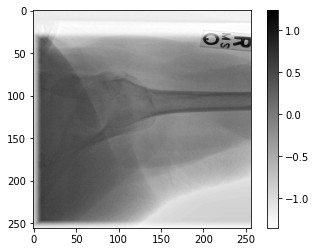

In [ ]:
print_img_with_colorbar(X_train[0])

We observe that the XR, has label R(right) or L(left) and some metadata(Q, MS) on top of the image

(We may need to tranform the image as they need to extract labels)

In [ ]:
def print_range_images(images, images_label):
    '''
    print the first 25 images with their labels
    
    images: a array of images
    images_label: a array with the label of each image
    class_names: a list with the labels name of each class
    '''
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(images_label[i])

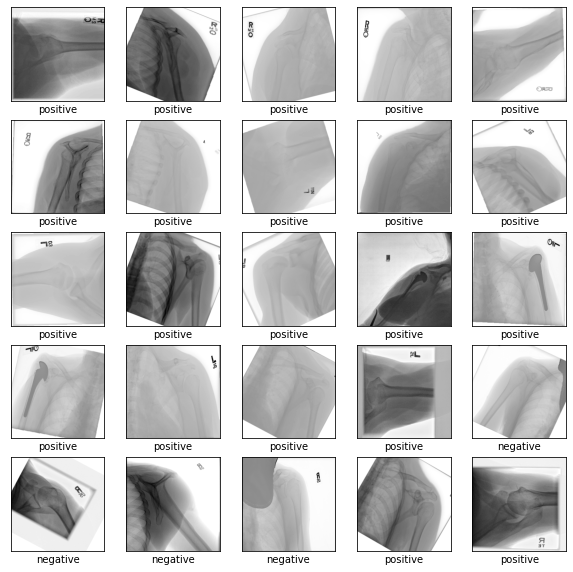

In [ ]:
print_range_images(X_train, y_train)

We can see that most of the images are randomly rotated, randomly resized of images and  randomly resized of labels. Moreover, some labels can not see easily or do not exist

(We may need to tranform the image as they need to be centered)

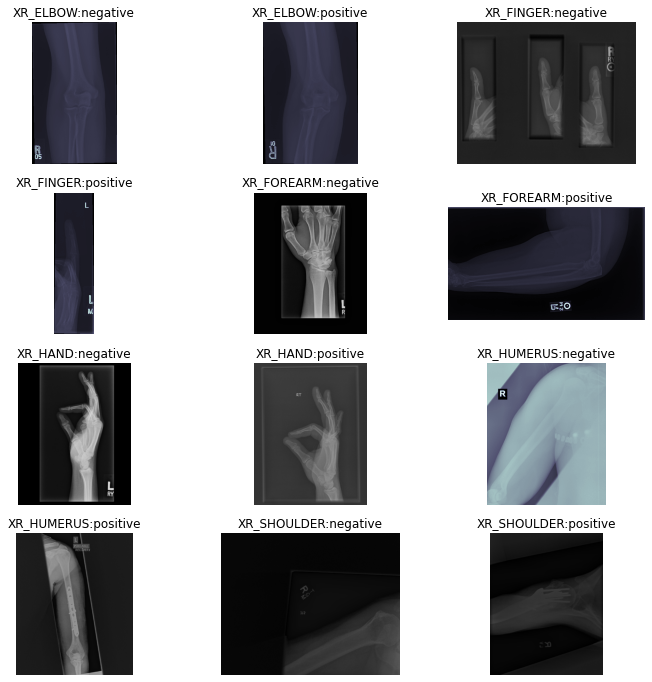

In [ ]:
# https://www.kaggle.com/kmader/mura-data-overview
from skimage.io import imread

sub_df = train_images_paths.groupby(['category', 'label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['image_path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{category}:{label}'.format(**c_row))

fig.savefig('samples.png', dpi = 300)

We can see that the images do not have same colour or clearness. 

(We may need to tranform to grayscale all images and contrast)

# Machine Learning Models

## Splitting dataset

**Old dimensions**

In [26]:
train_images_paths.shape

(36808, 5)

In [27]:
valid_data_paths.shape

(3197, 6)

**New dimensions**

In [28]:
train, valid = train_test_split(train_images_paths, 
                               test_size=0.2,
                               random_state=seed)

In [29]:
train.shape

(29446, 5)

In [30]:
valid.shape

(7362, 5)

In [31]:
test = valid_data_paths.drop(['dir'], axis=1)
test.shape

(3197, 5)

## Image Preparing

In [32]:
im_size = 256

In [33]:
train.columns

Index(['image_path', 'label', 'category', 'patientId', 'label_index'], dtype='object')

In [34]:
image_generator_settings = dict(
                          rescale = 1. / 255
                          #samplewise_center = True,
                          #samplewise_std_normalization = True,
                          #rotation_range = 5, 
                         )

image_generator = ImageDataGenerator(**image_generator_settings)

In [35]:
     path = 'MURA-v1.1'

In [36]:
train_generator = image_generator.flow_from_dataframe(
    dataframe = train,
    directory = None,
    x_col = 'image_path',
    y_col = 'label_index',
    batch_size = 64,
    shuffle = True,
    class_mode = 'raw', #"binary"
    target_size = (im_size, im_size),
    color_mode = 'rgb',#'grayscale'
    interpolation='nearest', #default
    validate_filenames=False,
    seed=seed)

Found 29446 non-validated image filenames.


In [37]:
valid_generator = image_generator.flow_from_dataframe(
    dataframe = valid,
    directory = None,
    x_col = 'image_path',
    y_col = 'label_index', #'labels'
    batch_size = 64,
    shuffle = True,
    class_mode = 'raw', #"binary"
    target_size = (im_size, im_size),
    color_mode = 'rgb',#'grayscale'
    interpolation='nearest', #default
    validate_filenames=True,
    seed=seed)

Found 7362 validated image filenames.


In [38]:
test_generator = image_generator.flow_from_dataframe(
    dataframe = test,
    directory = None,
    x_col = 'image_path',
    y_col = 'label_index', #'labels'
    batch_size = 64,
    shuffle = False,
    class_mode = 'raw', #"binary"
    target_size = (im_size, im_size),
    color_mode = 'rgb',#'grayscale'
    interpolation='nearest', #default
    validate_filenames=True,
    seed=seed)

Found 3197 validated image filenames.


## Initialization

In [39]:
# normal or abnormal
CLASSES = 2

In [40]:
#Plus the last dimension, type is tuple
#because it is grayscale: we add 1 channel 
#(if we have rbg we put 3 as channels)
input_shape = (im_size,im_size,3)   
print(input_shape)

(256, 256, 3)


### Metrics

In [41]:
def metrics():
    return [
        AUC(name="auc"),
        BinaryAccuracy("accuracy"),
        CohenKappa(name="kappa", num_classes=2)
    ]

### Plotting results

In [42]:
def plot_history(hs, epochs, metric):

    if metric=='loss': 
                label_y = 'Loss'
    elif metric=='accuracy': 
               label_y = 'Accuracy'
    elif metric=='auc': 
               label_y = 'AUC'
    else : label_y = 'kappa'


    print()
    #plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(label_y)
    plt.legend()
    plt.show()

In [43]:
def print_results(model_name,
                  epochs,
                  hs,
                  model_eval):

    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(model_eval[0]))
    print("---")
    print("Train AUC     : {0:.5f}".format(hs.history['auc'][-1]))
    print("Validation AUC: {0:.5f}".format(hs.history['val_auc'][-1]))
    print("Test AUC      : {0:.5f}".format(model_eval[1]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(model_eval[2]))
    print("---")
    print("Train Kappa     : {0:.5f}".format(hs.history['kappa'][-1]))
    print("Validation Kappa: {0:.5f}".format(hs.history['kappa'][-1]))
    print("Test Kappa      : {0:.5f}".format(model_eval[3]))


    # Plot train and validation error per epoch.
    plot_history(hs={model_name: hs}, epochs=epochs, metric='loss')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='auc')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='accuracy')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='kappa')

### Cleaning up

In [44]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect() #garbage collection
    print("...Finished clean up...")

We will use a `Functional Model` of tensorflow as it is more flexible (not `Sequential`, with add layers)

In [45]:
### miss code: check momentum SGD vs Adam vs SGD vs AdaBound###

### Προσοχή στο Early Stopping, αν εξαντησουθμε όλες,###
###θελουμε να μεγαλωσουμε τις εποχες###

# CNN θελουμε αρκετα βαθύ δίκτυο

# Να βαλουμε και MLP πριν τον classifier MlP στο τελος

## CNN

### Architecture

In [ ]:
def cnn_builder(
        input_shape=(256, 256, 3), # if we want grayscale = 1
        starting_filters=32,
        conv_layers=1,
        conv_strides=(1, 1),
        conv_kernel=(3, 3),
        convs_per_layer=1,
        batch_norm=False,
        pooling="max",
        dropout=None,
        pool_size=(2, 2),
        pool_strides=(2, 2),
        last_pooling=None,
        spatial_dropout=None,
        last_dropout=None,
):
    
    # Define the input layer.
    inputs = Input(
        shape=input_shape,
        name="input"
    )

    x = inputs

    # Define the convolutional layers.
    for conv_level in range(conv_layers):
        
        current_filters = starting_filters * (2 ** conv_level)
        
        for conv_number in range(convs_per_layer):
            
            x = Conv2D(
                filters=current_filters,
                kernel_size=conv_kernel,
                strides=conv_strides,
                name=f"conv_{conv_level}_{conv_number}",
                padding='same'
            )(x)
            
            if batch_norm:
                x = BatchNormalization(name=f"bn_{conv_level}_{conv_number}")(x)
            
            x = Activation("relu", name=f"conv_{conv_level}_{conv_number}_relu")(x)

        if spatial_dropout:
            x = SpatialDropout2D(spatial_dropout, name=f"sp_dropout_{conv_level}")(x)

        if pooling == 'avg':
            x = AvgPool2D(pool_size=pool_size, 
                          strides=pool_strides,
                          name=f"mp_{conv_level}",
                          padding='same')(x)
        elif pooling == 'max':
            x = MaxPool2D(pool_size=pool_size,
                          strides=pool_strides,
                          name=f"mp_{conv_level}",
                          padding='same')(x)

        if dropout:
            x = Dropout(dropout, name=f"dropout_{conv_level}")(x)

    if last_pooling == "avg":
        x = GlobalAveragePooling2D(name=f"lp_{last_pooling}")(x)
    elif last_pooling == "max":
        x = GlobalMaxPooling2D(name=f"lp_{last_pooling}")(x)

    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name="flatten")(x)

    if last_dropout:
        x = Dropout(last_dropout, name="last_dp")(x)

    # Define the output layer.
    output = Dense(1, activation='sigmoid', name="output")(x)

    # Define the model and train it.
    model = Model(inputs=inputs, outputs=output)
    
    return model

### Models

#### (model_1) CNN basic

In [ ]:
epochs = 100

In [ ]:
cnn_model = cnn_builder(starting_filters=32,
                                      conv_layers=4,
                                      convs_per_layer=1,
                                      pooling='max')

In [ ]:
############ Compile Model ############
    
cnn_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])

In [ ]:
early_stop = EarlyStopping(monitor="val_loss", #"kappa",
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)

############ Fit Model ################
hs = cnn_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop]
    )
    
print('Finished training.')
    
print('------------------')
cnn_model.summary() # Print a description of the model.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


Epoch 1/100
461/461 [==============================] - 217s 395ms/step - loss: 0.6608 - auc: 0.5909 - accuracy: 0.6020 - kappa: 0.0477 - val_loss: 0.6576 - val_auc: 0.6249 - val_accuracy: 0.6073 - val_kappa: 0.1246
Epoch 2/100
461/461 [==============================] - 178s 385ms/step - loss: 0.6441 - auc: 0.6383 - accuracy: 0.6205 - kappa: 0.1331 - val_loss: 0.6421 - val_auc: 0.6580 - val_accuracy: 0.6197 - val_kappa: 0.1236
Epoch 3/100
461/461 [==============================] - 166s 359ms/step - loss: 0.6206 - auc: 0.6809 - accuracy: 0.6469 - kappa: 0.2180 - val_loss: 0.6265 - val_auc: 0.6966 - val_accuracy: 0.6472 - val_kappa: 0.1970
Epoch 4/100
461/461 [==============================] - 162s 351ms/step - loss: 0.5888 - auc: 0.7267 - accuracy: 0.6840 - kappa: 0.3070 - val_loss: 0.6035 - val_auc: 0.7155 - val_accuracy: 0.6694 - val_kappa: 0.2745
Epoch 5/100
461/461 [==============================] - 162s 352ms/step - loss: 0.5547 - auc: 0.7683 - accuracy: 0.7129 - kappa: 0.3778 - val

In [ ]:
# save model
filename = 'models/model_1.h5'
cnn_model.save(filename)
print('>Saved %s' % filename)

# Evaluate on test data and show all the results.
cnn_model_eval = cnn_model.evaluate(test_generator)
clean_up(model=cnn_model)

>Saved models/model_1.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


50/50 [==============================] - 18s 363ms/step - loss: 0.6322 - auc: 0.7043 - accuracy: 0.6497 - kappa: 0.2908
...Finished clean up...


Train Loss     : 0.09284
Validation Loss: 1.75171
Test Loss      : 0.63218
---
Train AUC     : 0.99450
Validation AUC: 0.69432
Test AUC      : 0.70425
---
Train Accuracy     : 0.96465
Validation Accuracy: 0.65838
Test Accuracy      : 0.64967
---
Train Kappa     : 0.92640
Validation Kappa: 0.92640
Test Kappa      : 0.29082



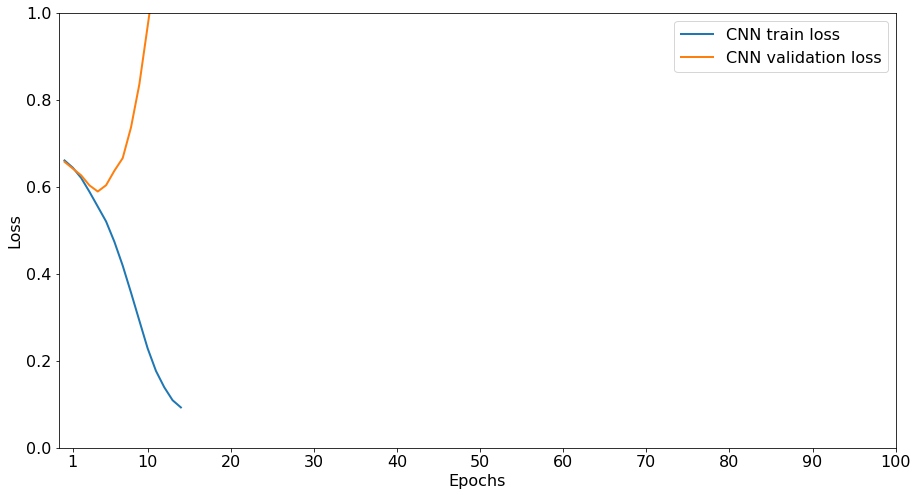

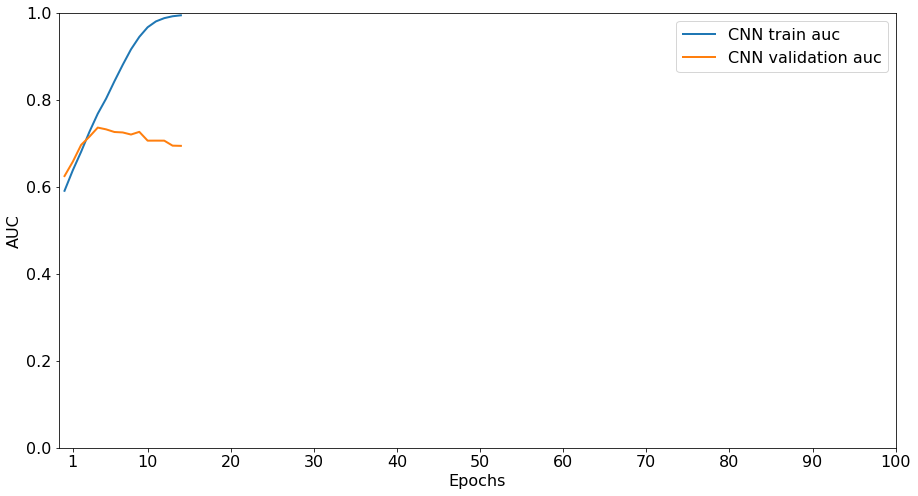

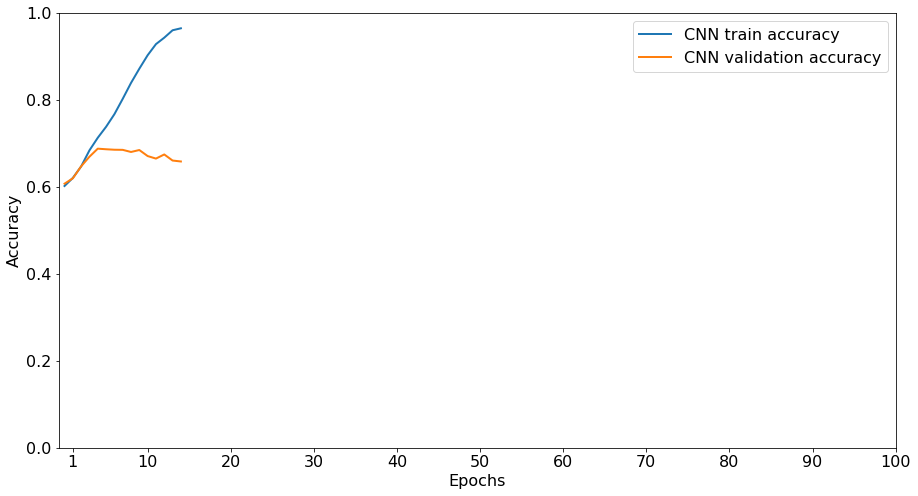

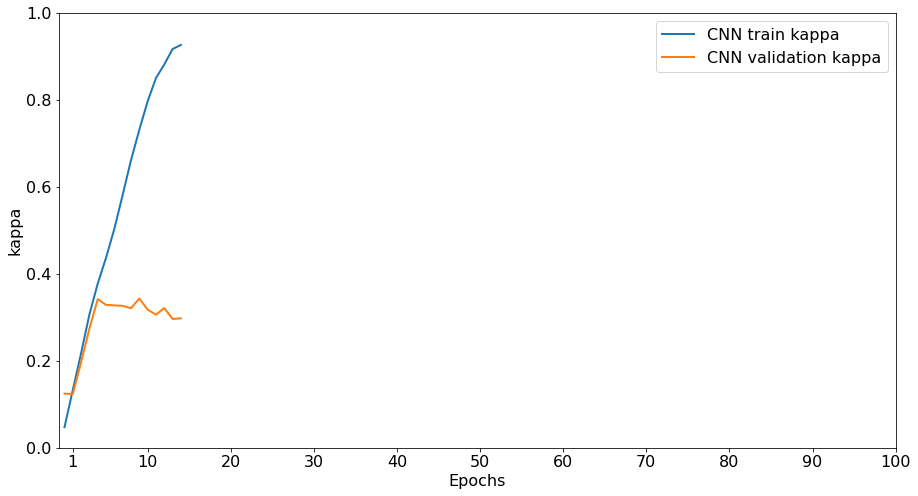

In [ ]:
print_results(model_name='CNN',
                  epochs= epochs,
                  hs = hs,
                  model_eval = cnn_model_eval)

#### (model_2) CNN basic with more

In [ ]:
early_stop = EarlyStopping(monitor="val_loss", #"kappa",
                           mode="min", 
                           patience=5, 
                           restore_best_weights=True)

epochs = 30

cnn_model = cnn_builder(starting_filters=16,
                                      conv_layers=4,
                                      convs_per_layer=2,
                                      pooling='max')

############ Compile Model ############
    
cnn_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])

############ Fit Model ################
hs = cnn_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop]
    )
    
print('Finished training.')
    
print('------------------')
cnn_model.summary() # Print a description of the model.

Epoch 1/30
461/461 [==============================] - ETA: 0s - loss: 0.6620 - auc: 0.5830 - accuracy: 0.5988 - kappa: 0.0232

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


461/461 [==============================] - 175s 370ms/step - loss: 0.6620 - auc: 0.5830 - accuracy: 0.5988 - kappa: 0.0232 - val_loss: 0.6557 - val_auc: 0.6278 - val_accuracy: 0.5936 - val_kappa: 0.0208
Epoch 2/30
461/461 [==============================] - 168s 364ms/step - loss: 0.6481 - auc: 0.6239 - accuracy: 0.6124 - kappa: 0.1014 - val_loss: 0.6488 - val_auc: 0.6408 - val_accuracy: 0.6046 - val_kappa: 0.0645
Epoch 3/30
461/461 [==============================] - 168s 364ms/step - loss: 0.6387 - auc: 0.6463 - accuracy: 0.6233 - kappa: 0.1505 - val_loss: 0.6401 - val_auc: 0.6535 - val_accuracy: 0.6172 - val_kappa: 0.1626
Epoch 4/30
461/461 [==============================] - 168s 364ms/step - loss: 0.6304 - auc: 0.6639 - accuracy: 0.6353 - kappa: 0.1916 - val_loss: 0.6385 - val_auc: 0.6555 - val_accuracy: 0.6213 - val_kappa: 0.1752
Epoch 5/30
461/461 [==============================] - 168s 365ms/step - loss: 0.6169 - auc: 0.6884 - accuracy: 0.6527 - kappa: 0.2370 - val_loss: 0.6387 - 

In [ ]:
# save model
filename = 'models/model_2.h5'
cnn_model.save(filename)
print('>Saved %s' % filename)

# Evaluate on test data and show all the results.
cnn_model_eval = cnn_model.evaluate(test_generator)
clean_up(model=cnn_model)

>Saved models/model_2.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


50/50 [==============================] - 15s 306ms/step - loss: 0.6541 - auc: 0.6832 - accuracy: 0.6293 - kappa: 0.2515
...Finished clean up...


Train Loss     : 0.40817
Validation Loss: 0.77520
Test Loss      : 0.65413
---
Train AUC     : 0.88792
Validation AUC: 0.69493
Test AUC      : 0.68325
---
Train Accuracy     : 0.81023
Validation Accuracy: 0.64588
Test Accuracy      : 0.62934
---
Train Kappa     : 0.60076
Validation Kappa: 0.60076
Test Kappa      : 0.25151



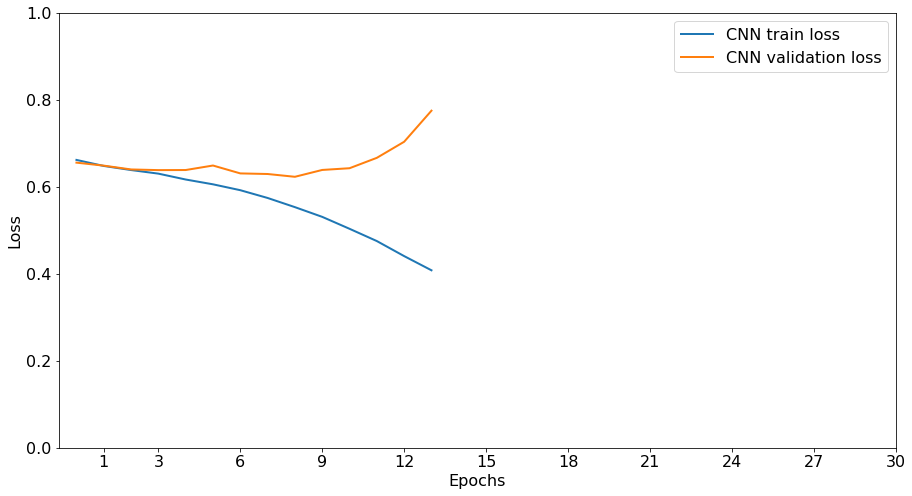

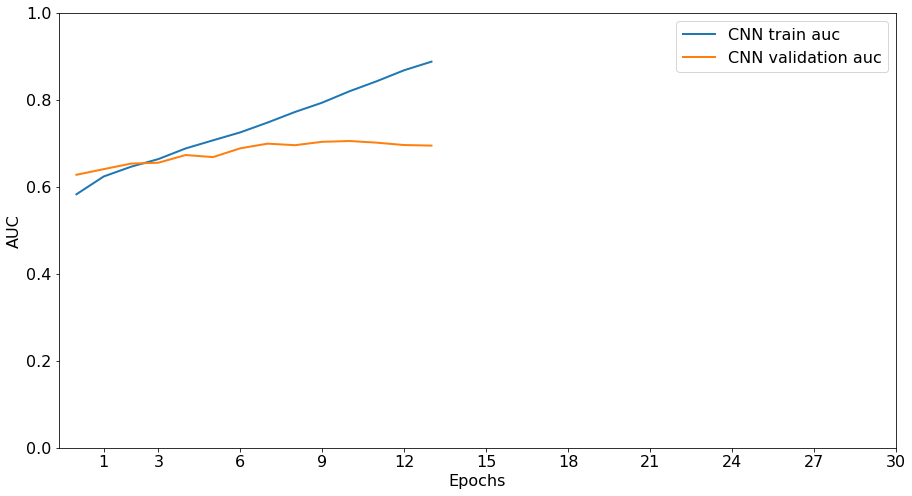

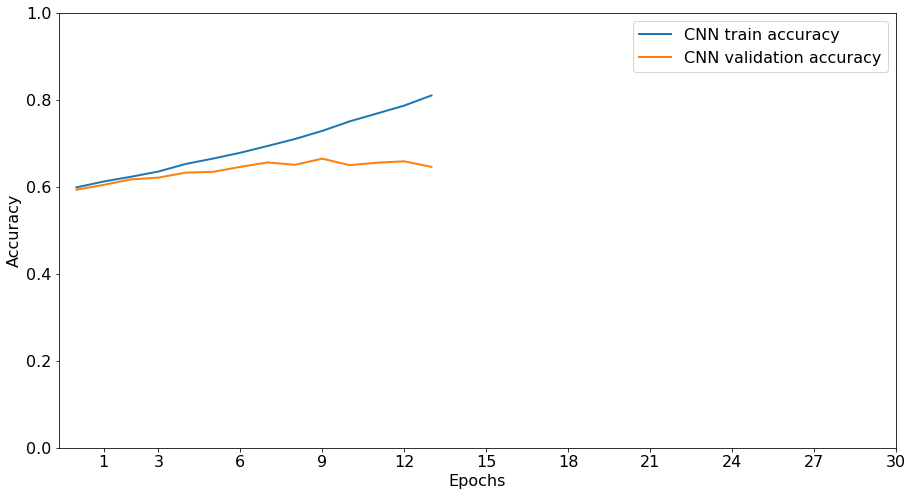

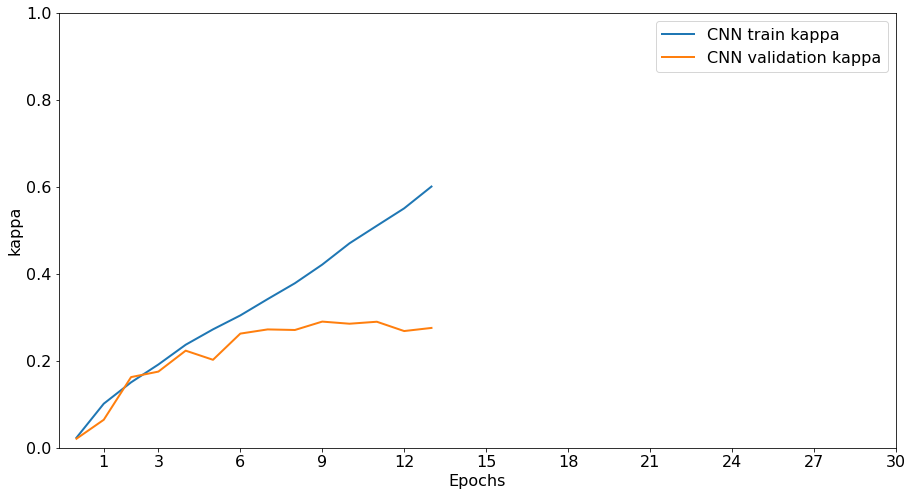

In [ ]:
print_results(model_name='CNN',
                  epochs= epochs,
                  hs = hs,
                  model_eval = cnn_model_eval)

#### (model_3) CNN more complex

In [ ]:
epochs = 40

cnn_model = cnn_builder(starting_filters=32,
                                conv_layers=4,
                                convs_per_layer=1,
                                pooling='avg',
                                batch_norm=True,
                                dropout=0.2,
                                pool_strides=(2, 2)
                               )

############ Compile Model ############
    
cnn_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])

############ Fit Model ################
hs = cnn_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop]
    )
    
print('Finished training.')
    
print('------------------')
cnn_model.summary() # Print a description of the model.

Epoch 1/40
461/461 [==============================] - ETA: 0s - loss: 0.9207 - auc: 0.5475 - accuracy: 0.5607 - kappa: 0.0619

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


461/461 [==============================] - 174s 371ms/step - loss: 0.9207 - auc: 0.5475 - accuracy: 0.5607 - kappa: 0.0619 - val_loss: 0.7540 - val_auc: 0.5854 - val_accuracy: 0.4746 - val_kappa: 0.0590
Epoch 2/40
461/461 [==============================] - 171s 370ms/step - loss: 0.7077 - auc: 0.5865 - accuracy: 0.5924 - kappa: 0.1102 - val_loss: 0.7007 - val_auc: 0.6164 - val_accuracy: 0.6073 - val_kappa: 0.1574
Epoch 3/40
461/461 [==============================] - 171s 372ms/step - loss: 0.6697 - auc: 0.6085 - accuracy: 0.6059 - kappa: 0.1313 - val_loss: 0.7261 - val_auc: 0.6169 - val_accuracy: 0.5875 - val_kappa: 0.0195
Epoch 4/40
461/461 [==============================] - 172s 372ms/step - loss: 0.6501 - auc: 0.6331 - accuracy: 0.6181 - kappa: 0.1484 - val_loss: 0.6723 - val_auc: 0.6264 - val_accuracy: 0.5648 - val_kappa: 0.1593
Epoch 5/40
461/461 [==============================] - 170s 369ms/step - loss: 0.6453 - auc: 0.6402 - accuracy: 0.6248 - kappa: 0.1629 - val_loss: 0.6509 - 

In [ ]:
# save model
filename = 'models/model_3.h5'
cnn_model.save(filename)
print('>Saved %s' % filename)

# Evaluate on test data and show all the results.
cnn_model_eval = cnn_model.evaluate(test_generator)
clean_up(model=cnn_model)

>Saved models/model_3.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


50/50 [==============================] - 15s 300ms/step - loss: 0.6342 - auc: 0.7167 - accuracy: 0.6581 - kappa: 0.3077
...Finished clean up...


Train Loss     : 0.44815
Validation Loss: 0.85330
Test Loss      : 0.63419
---
Train AUC     : 0.86130
Validation AUC: 0.65808
Test AUC      : 0.71669
---
Train Accuracy     : 0.78839
Validation Accuracy: 0.63923
Test Accuracy      : 0.65812
---
Train Kappa     : 0.55070
Validation Kappa: 0.55070
Test Kappa      : 0.30771



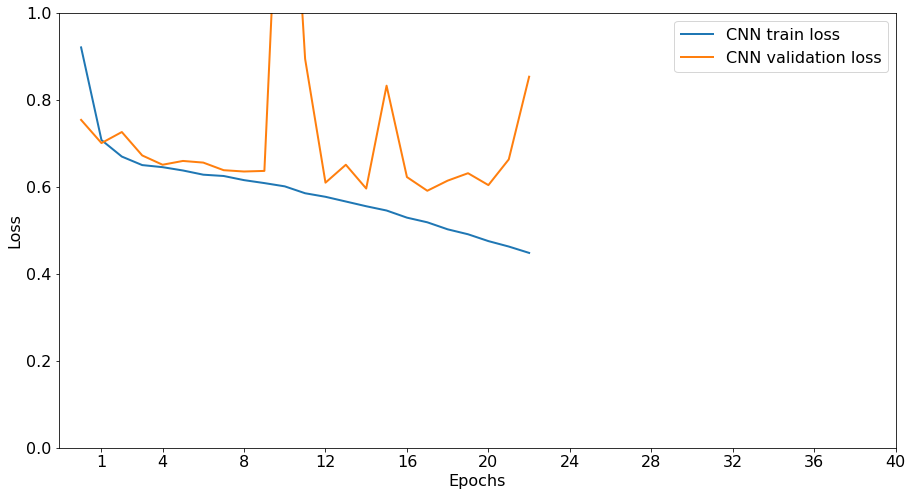

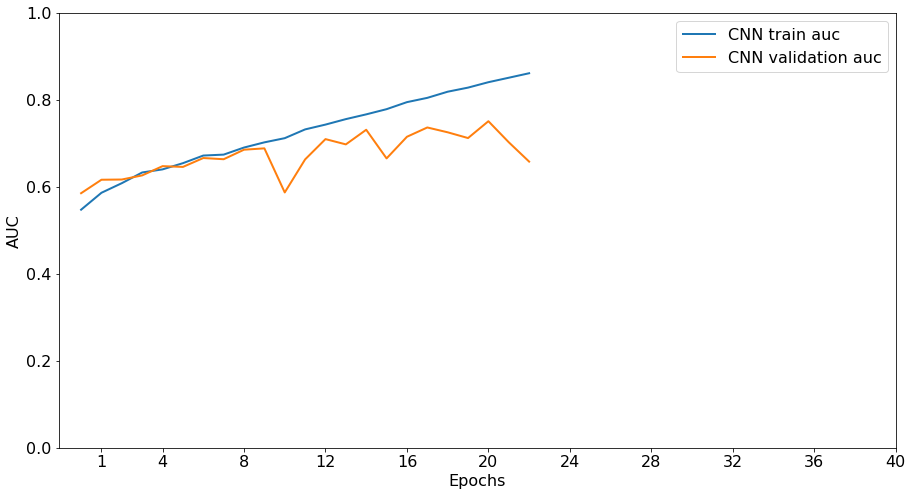

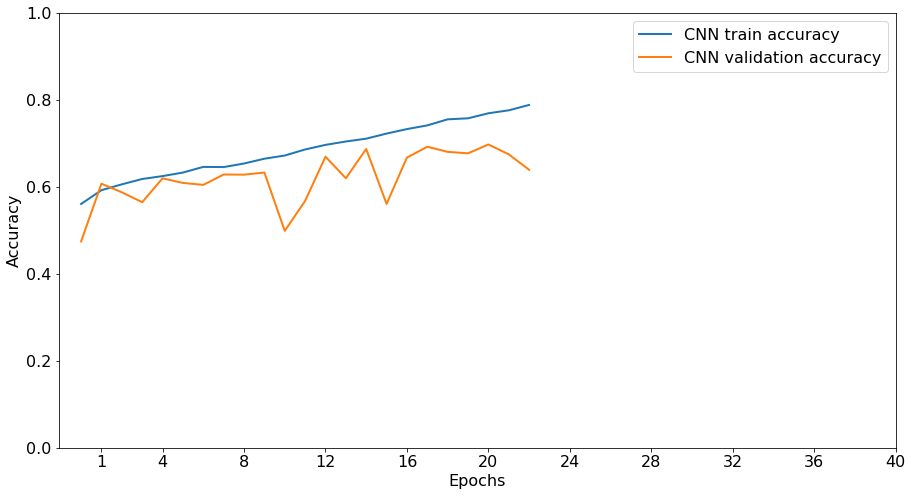

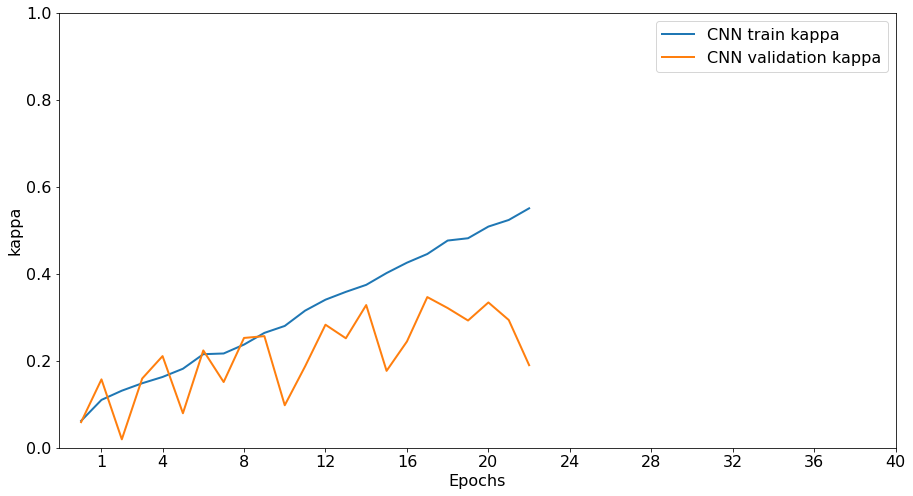

In [ ]:
print_results(model_name='CNN',
                  epochs= epochs,
                  hs = hs,
                  model_eval = cnn_model_eval)

#### (model_4) CNN with Adam Bound

In [ ]:
epochs = 50

early_stop = EarlyStopping(monitor="val_loss", #"kappa",
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)

cnn_model = cnn_builder(starting_filters=32,
                                conv_layers=4,
                                convs_per_layer=1,
                                pooling='avg',
                                batch_norm=True,
                                dropout=0.2,
                                pool_strides=(2, 2)
                               )

############ Compile Model ############
    
cnn_model.compile(optimizer=AdaBound(lr=1e-3, final_lr=0.1), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])

############ Fit Model ################
hs = cnn_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop]
    )
    
print('Finished training.')
    
print('------------------')
cnn_model.summary() # Print a description of the model.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
461/461 [==============================] - ETA: 0s - loss: 1.0455 - auc: 0.5431 - accuracy: 0.5567 - kappa: 0.0559

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


461/461 [==============================] - 207s 375ms/step - loss: 1.0455 - auc: 0.5431 - accuracy: 0.5567 - kappa: 0.0559 - val_loss: 0.7117 - val_auc: 0.6026 - val_accuracy: 0.5797 - val_kappa: 0.0031
Epoch 2/50
461/461 [==============================] - 173s 376ms/step - loss: 0.6871 - auc: 0.5850 - accuracy: 0.5881 - kappa: 0.0985 - val_loss: 0.6478 - val_auc: 0.6374 - val_accuracy: 0.6130 - val_kappa: 0.1292
Epoch 3/50
461/461 [==============================] - 172s 373ms/step - loss: 0.6556 - auc: 0.6171 - accuracy: 0.6112 - kappa: 0.1317 - val_loss: 0.6763 - val_auc: 0.6369 - val_accuracy: 0.5626 - val_kappa: 0.1651
Epoch 4/50
461/461 [==============================] - 174s 378ms/step - loss: 0.6457 - auc: 0.6370 - accuracy: 0.6241 - kappa: 0.1578 - val_loss: 0.6503 - val_auc: 0.6407 - val_accuracy: 0.6172 - val_kappa: 0.1177
Epoch 5/50
461/461 [==============================] - 173s 374ms/step - loss: 0.6422 - auc: 0.6443 - accuracy: 0.6269 - kappa: 0.1620 - val_loss: 0.6467 - 

In [ ]:
# save model
filename = 'models/model_4.h5'
cnn_model.save(filename)
print('>Saved %s' % filename)

# Evaluate on test data and show all the results.
cnn_model_eval = cnn_model.evaluate(test_generator)
clean_up(model=cnn_model)

>Saved models/model_4.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


50/50 [==============================] - 13s 267ms/step - loss: 0.6448 - auc: 0.7079 - accuracy: 0.6528 - kappa: 0.2976
...Finished clean up...


Train Loss     : 0.47791
Validation Loss: 0.62204
Test Loss      : 0.64484
---
Train AUC     : 0.84007
Validation AUC: 0.72862
Test AUC      : 0.70790
---
Train Accuracy     : 0.76910
Validation Accuracy: 0.67291
Test Accuracy      : 0.65280
---
Train Kappa     : 0.50891
Validation Kappa: 0.50891
Test Kappa      : 0.29764



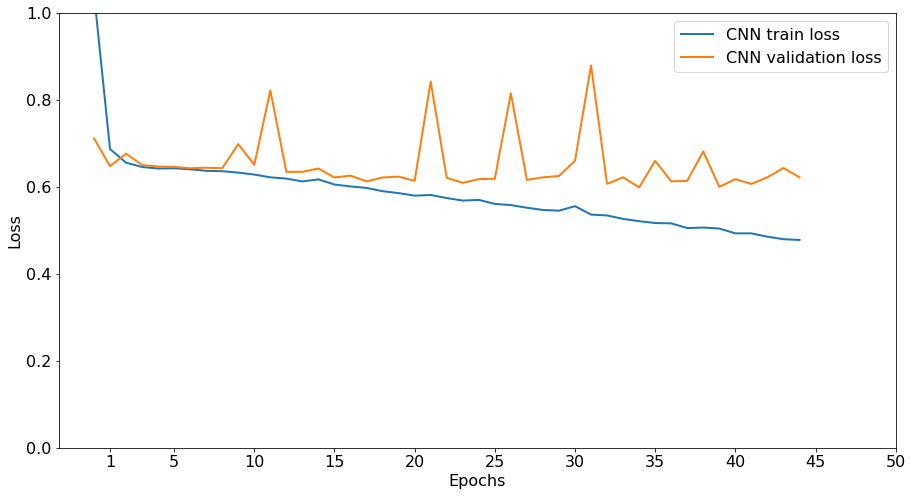

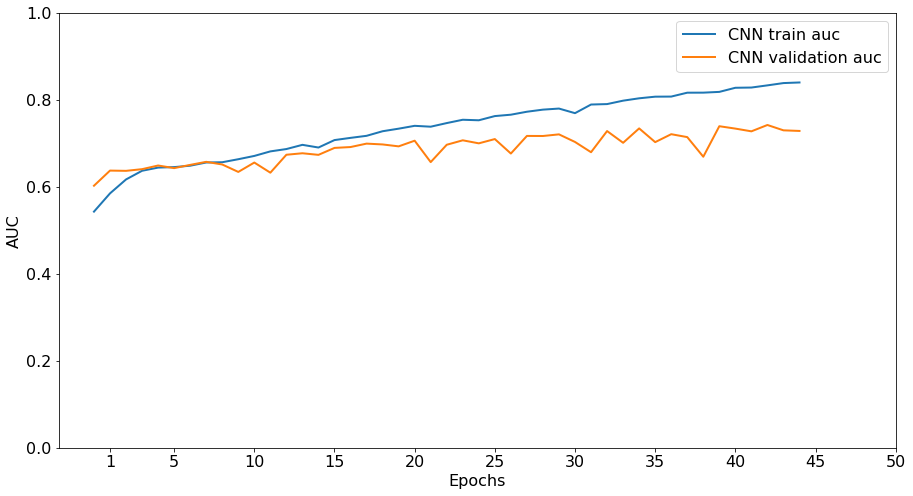

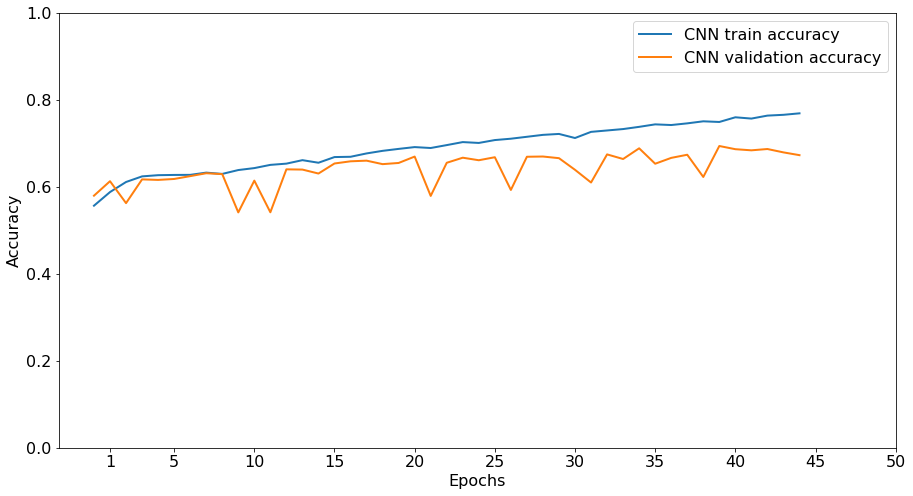

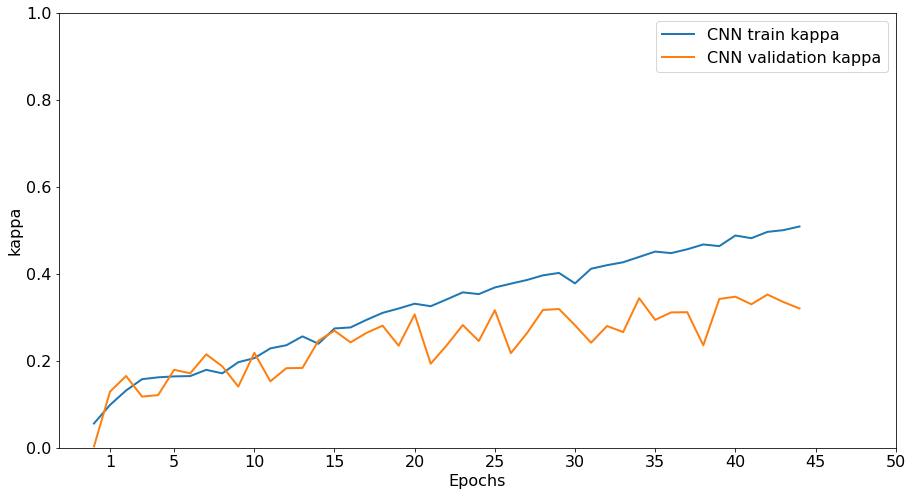

In [ ]:
print_results(model_name='CNN',
                  epochs= epochs,
                  hs = hs,
                  model_eval = cnn_model_eval)

## Resnet

### Info

**The structure**: ResNet network uses a 34-layer plain network architecture inspired by VGG-19 in which then the shortcut connection is added. These shortcut connections then convert the architecture into the residual network as shown in the figure below:
<img src='https://d1m75rqqgidzqn.cloudfront.net/wp-data/2020/09/09194511/0_Si4ckM1MrkUxTaDH.png'>

### Architecture

In [ ]:
def resnet_builder(
        pooling="max", 
        shape=(256, 256, 3), 
        trainable_layers_after=None
    ):

    resNet = ResNet152V2(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )

    if trainable_layers_after:
        for layer in resNet.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        resNet.trainable = False

    prediction_layer = Dense(1, activation="sigmoid",
                                name="resnet_output_sigmoid")
    
    model = Sequential(
        layers=[
            resNet,
            prediction_layer
        ],
        name="resnet"
    )

    return model

### Models

#### (model_5) ResNet

In [ ]:
epochs = 10

early_stop = EarlyStopping(monitor="kappa", # "val_loss", #"kappa",
                           mode="min", 
                           patience=3, 
                           restore_best_weights=True)

resnet_model = resnet_builder(pooling='avg')

############ Compile Model ############
    
resnet_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])

############ Fit Model ################
hs = resnet_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop]
    )
    
print('Finished training.')
    
print('------------------')
resnet_model.summary() # Print a description of the model.

234553344/234545216 [==============================] - 2s 0us/step
Epoch 1/10
461/461 [==============================] - ETA: 0s - loss: 0.5793 - auc: 0.7422 - accuracy: 0.7014 - kappa: 0.3550

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


461/461 [==============================] - 352s 679ms/step - loss: 0.5793 - auc: 0.7422 - accuracy: 0.7014 - kappa: 0.3550 - val_loss: 0.5463 - val_auc: 0.7867 - val_accuracy: 0.7264 - val_kappa: 0.4272
Epoch 2/10
461/461 [==============================] - 320s 693ms/step - loss: 0.5334 - auc: 0.7920 - accuracy: 0.7398 - kappa: 0.4409 - val_loss: 0.5694 - val_auc: 0.7996 - val_accuracy: 0.7202 - val_kappa: 0.3721
Epoch 3/10
461/461 [==============================] - 320s 694ms/step - loss: 0.5213 - auc: 0.8024 - accuracy: 0.7483 - kappa: 0.4597 - val_loss: 0.5264 - val_auc: 0.8058 - val_accuracy: 0.7502 - val_kappa: 0.4660
Epoch 4/10
461/461 [==============================] - 319s 693ms/step - loss: 0.5126 - auc: 0.8106 - accuracy: 0.7551 - kappa: 0.4747 - val_loss: 0.5519 - val_auc: 0.8082 - val_accuracy: 0.7325 - val_kappa: 0.4060
Finished training.
------------------
Model: "resnet"
_________________________________________________________________
Layer (type)                 Output

In [ ]:
# save model
filename = 'models/model_5.h5'
resnet_model.save(filename)
print('>Saved %s' % filename)

# Evaluate on test data and show all the results.
resnet_model_eval = resnet_model.evaluate(test_generator)
clean_up(model=resnet_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


>Saved models/model_5.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


50/50 [==============================] - 30s 589ms/step - loss: 0.5535 - auc: 0.7883 - accuracy: 0.7210 - kappa: 0.4367
...Finished clean up...


Train Loss     : 0.51262
Validation Loss: 0.55185
Test Loss      : 0.55354
---
Train AUC     : 0.81060
Validation AUC: 0.80821
Test AUC      : 0.78835
---
Train Accuracy     : 0.75511
Validation Accuracy: 0.73255
Test Accuracy      : 0.72099
---
Train Kappa     : 0.47469
Validation Kappa: 0.47469
Test Kappa      : 0.43671



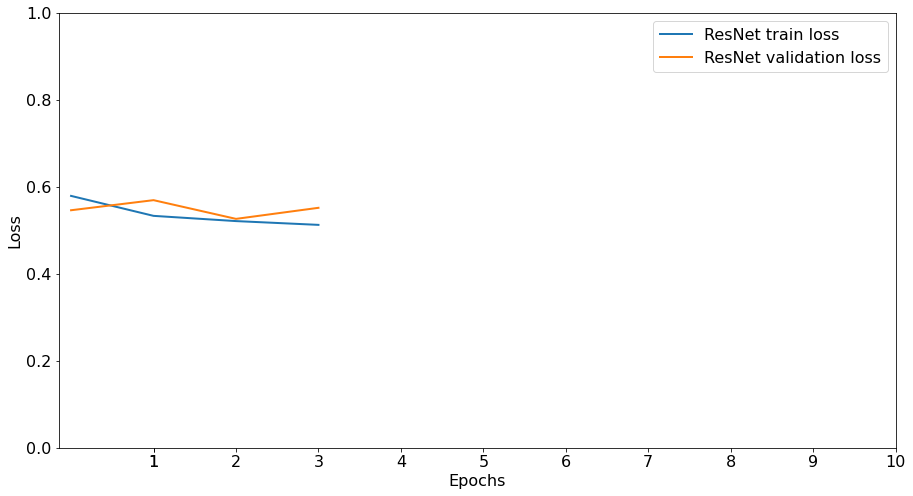

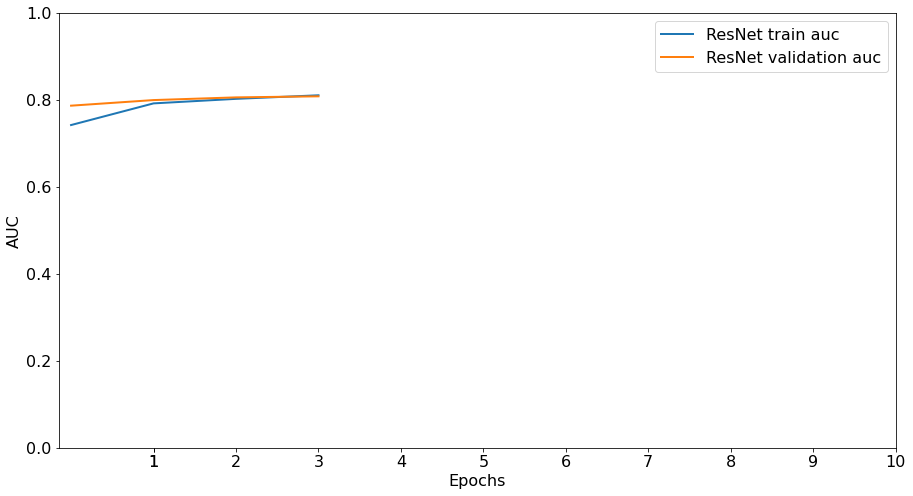

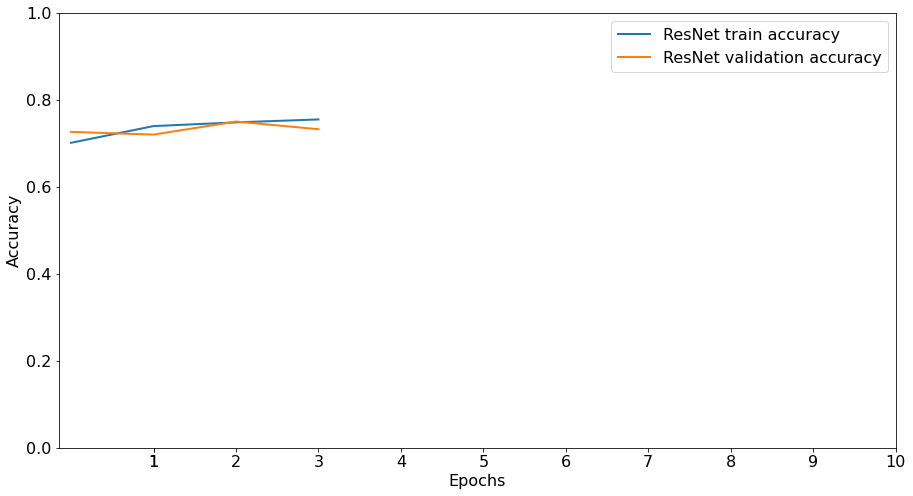

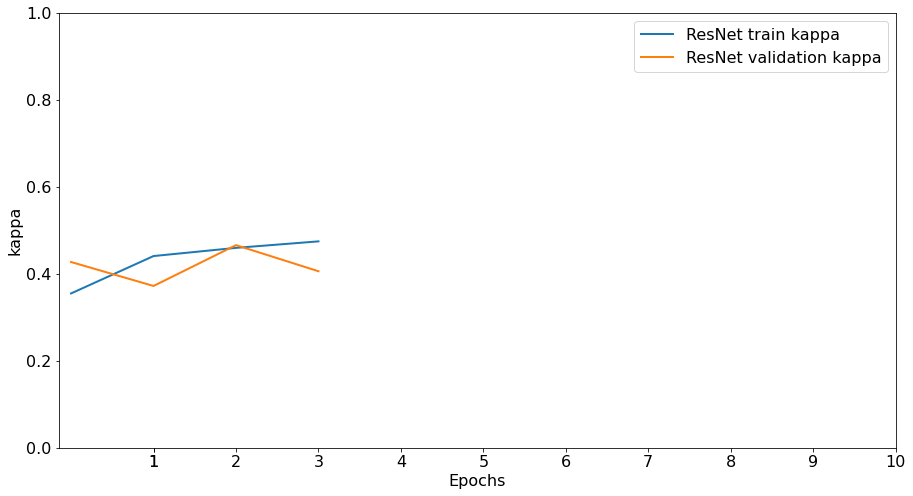

In [ ]:
print_results(model_name='ResNet',
                  epochs= epochs,
                  hs = hs,
                  model_eval = resnet_model_eval)

## Densenet

### Info

**The structure**:
Densenet contains a feature layer (convolutional layer) capturing low-level features from images, serveral dense blocks, and transition layers between adjacent dense blocks.

<img src='https://miro.medium.com/max/700/1*znemMaROmOd1CzMJlcI0aA.png'>



### Architecture

In [54]:
def densenet_builder(
        pooling="avg",
        shape=(256, 256, 3),
        trainable_layers_after=None,
        mlp=[],
        mlp_dropout=0.25,
        nameNN="",
):

    denseNet = DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )

    if trainable_layers_after:
        for layer in denseNet.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        denseNet.trainable = False

    output = denseNet.output

    
    for index, mlp_neurons in enumerate(mlp):
        output = Dense(mlp_neurons, activation="relu", name=f"m.{index}.{mlp_neurons}")(output)
        if mlp_dropout:
            output = Dropout(mlp_dropout, name=f"mdp.{index}.{mlp_neurons}")(output)

    output = Dense(1, activation="sigmoid", name="densenet_output_sigmoid")(output)

    model = Model(denseNet.input, output, name='densenet'+nameNN)

    return model

### Models

#### (model_6) DenseNet

In [ ]:
epochs = 50

early_stop = EarlyStopping(monitor="kappa",#"val_loss", 
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)

densenet_model = densenet_builder(
                            pooling='max', 
                            trainable_layers_after=600
                            )

############ Compile Model ############
    
densenet_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])

############ Fit Model ################
hs = densenet_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop]
    )
    
print('Finished training.')
    
print('------------------')
densenet_model.summary() # Print a description of the model.

Epoch 1/50
461/461 [==============================] - ETA: 0s - loss: 0.6379 - auc: 0.7737 - accuracy: 0.7255 - kappa: 0.4211

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


461/461 [==============================] - 239s 494ms/step - loss: 0.6379 - auc: 0.7737 - accuracy: 0.7255 - kappa: 0.4211 - val_loss: 0.7016 - val_auc: 0.8290 - val_accuracy: 0.7389 - val_kappa: 0.4119
Epoch 2/50
461/461 [==============================] - 225s 488ms/step - loss: 0.4669 - auc: 0.8554 - accuracy: 0.7909 - kappa: 0.5585 - val_loss: 0.5972 - val_auc: 0.8345 - val_accuracy: 0.7546 - val_kappa: 0.4559
Epoch 3/50
461/461 [==============================] - 225s 488ms/step - loss: 0.3998 - auc: 0.8922 - accuracy: 0.8235 - kappa: 0.6279 - val_loss: 0.5064 - val_auc: 0.8451 - val_accuracy: 0.7794 - val_kappa: 0.5422
Epoch 4/50
461/461 [==============================] - 225s 487ms/step - loss: 0.3097 - auc: 0.9360 - accuracy: 0.8707 - kappa: 0.7281 - val_loss: 0.5291 - val_auc: 0.8418 - val_accuracy: 0.7812 - val_kappa: 0.5393
Epoch 5/50
461/461 [==============================] - 225s 487ms/step - loss: 0.2373 - auc: 0.9637 - accuracy: 0.9026 - kappa: 0.7959 - val_loss: 0.6054 - 

In [ ]:
# save model
filename = 'models/model_6.h5'
densenet_model.save(filename)
print('>Saved %s' % filename)

# Evaluate on test data and show all the results.
densenet_model_eval = densenet_model.evaluate(test_generator)
clean_up(model=densenet_model)

>Saved models/model_6.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


50/50 [==============================] - 26s 511ms/step - loss: 0.8025 - auc: 0.8262 - accuracy: 0.7050 - kappa: 0.3952
...Finished clean up...


Train Loss     : 0.04305
Validation Loss: 0.89195
Test Loss      : 0.80246
---
Train AUC     : 0.99876
Validation AUC: 0.83295
Test AUC      : 0.82624
---
Train Accuracy     : 0.98563
Validation Accuracy: 0.75781
Test Accuracy      : 0.70504
---
Train Kappa     : 0.97011
Validation Kappa: 0.97011
Test Kappa      : 0.39516



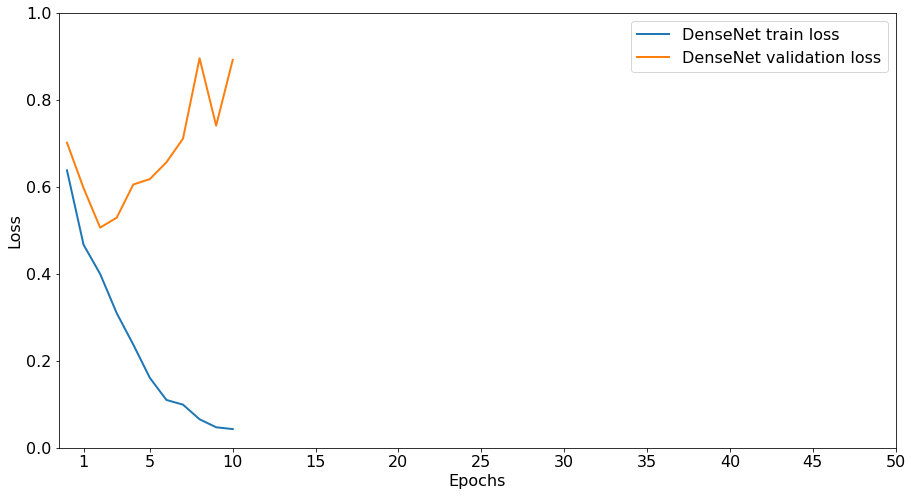

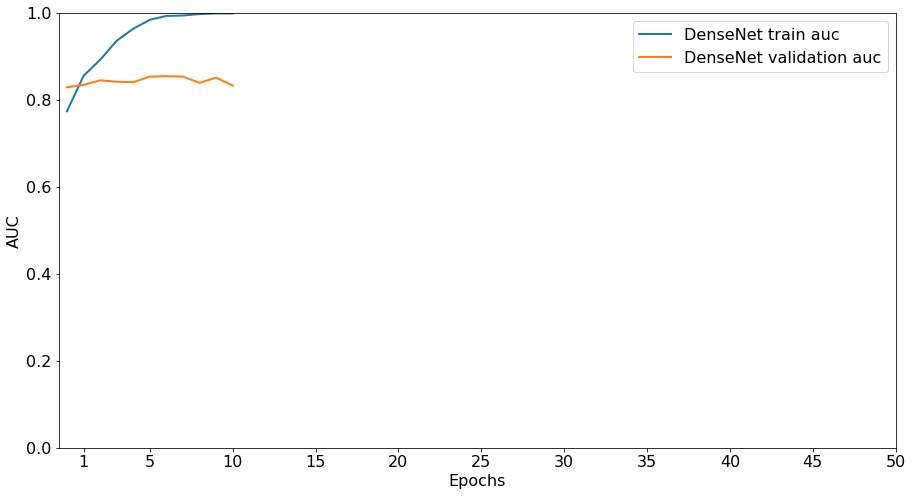

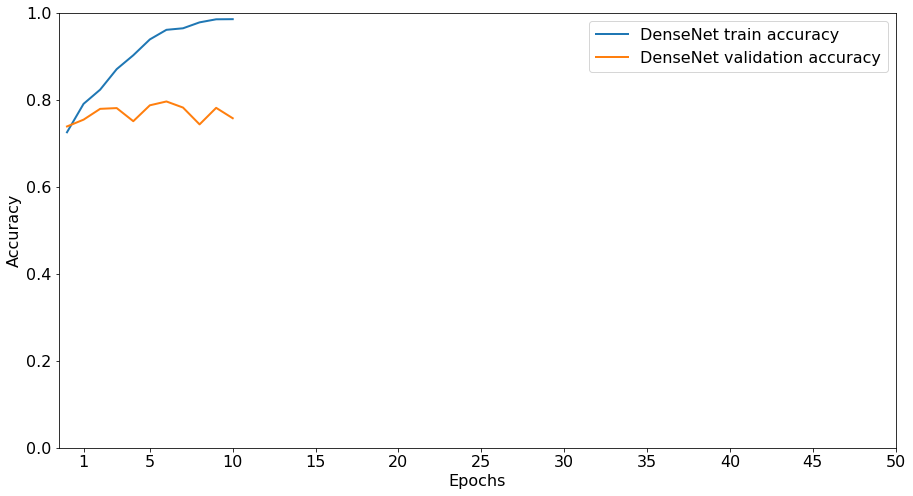

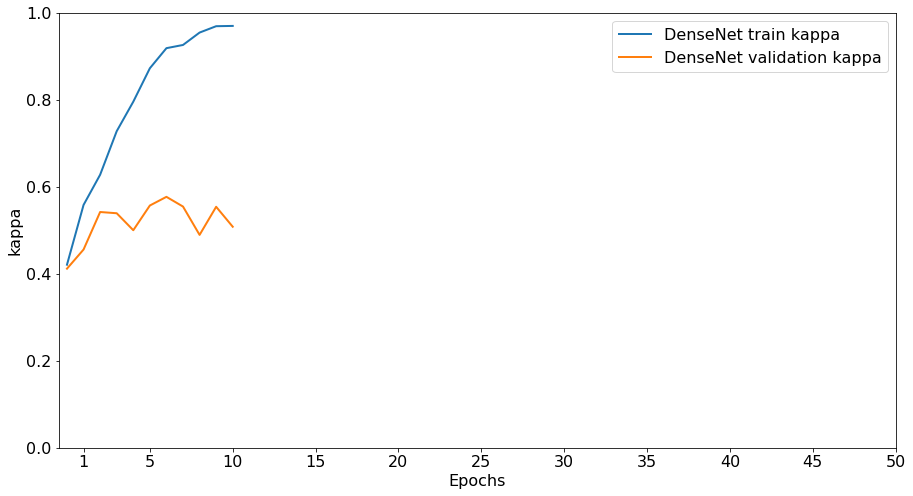

In [ ]:
print_results(model_name='DenseNet',
                  epochs= epochs,
                  hs = hs,
                  model_eval = densenet_model_eval)

#### (model_7) DenseNet

In [ ]:
epochs = 30

early_stop = EarlyStopping(monitor="kappa",#"val_loss", 
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)

densenet_model = densenet_builder(
                            pooling='avg',
                            trainable_layers_after=600,
                            mlp=[512, 512],
                            mlp_dropout=0.25)

############ Compile Model ############
    
densenet_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])

############ Fit Model ################
hs = densenet_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop]
    )
    
print('Finished training.')
    
print('------------------')
densenet_model.summary() # Print a description of the model.

Epoch 1/30
461/461 [==============================] - ETA: 0s - loss: 0.5228 - auc: 0.7991 - accuracy: 0.7527 - kappa: 0.4656

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


461/461 [==============================] - 240s 498ms/step - loss: 0.5228 - auc: 0.7991 - accuracy: 0.7527 - kappa: 0.4656 - val_loss: 0.5114 - val_auc: 0.8340 - val_accuracy: 0.7740 - val_kappa: 0.5042
Epoch 2/30
461/461 [==============================] - 224s 486ms/step - loss: 0.4606 - auc: 0.8488 - accuracy: 0.7948 - kappa: 0.5597 - val_loss: 0.4805 - val_auc: 0.8438 - val_accuracy: 0.7848 - val_kappa: 0.5495
Epoch 3/30
461/461 [==============================] - 225s 487ms/step - loss: 0.4253 - auc: 0.8731 - accuracy: 0.8144 - kappa: 0.6032 - val_loss: 0.4615 - val_auc: 0.8553 - val_accuracy: 0.7931 - val_kappa: 0.5709
Epoch 4/30
461/461 [==============================] - 225s 487ms/step - loss: 0.3937 - auc: 0.8910 - accuracy: 0.8337 - kappa: 0.6446 - val_loss: 0.4852 - val_auc: 0.8533 - val_accuracy: 0.7836 - val_kappa: 0.5533
Epoch 5/30
461/461 [==============================] - 224s 485ms/step - loss: 0.3570 - auc: 0.9119 - accuracy: 0.8500 - kappa: 0.6808 - val_loss: 0.5187 - 

In [ ]:
# save model
filename = 'models/model_7.h5'
densenet_model.save(filename)
print('>Saved %s' % filename)

# Evaluate on test data and show all the results.
densenet_model_eval = densenet_model.evaluate(test_generator)
clean_up(model=densenet_model)

>Saved models/model_7.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


50/50 [==============================] - 18s 344ms/step - loss: 0.5383 - auc: 0.8395 - accuracy: 0.7557 - kappa: 0.5025
...Finished clean up...


Train Loss     : 0.55130
Validation Loss: 0.56679
Test Loss      : 0.53834
---
Train AUC     : 0.78439
Validation AUC: 0.79857
Test AUC      : 0.83945
---
Train Accuracy     : 0.72767
Validation Accuracy: 0.73173
Test Accuracy      : 0.75571
---
Train Kappa     : 0.42192
Validation Kappa: 0.42192
Test Kappa      : 0.50246



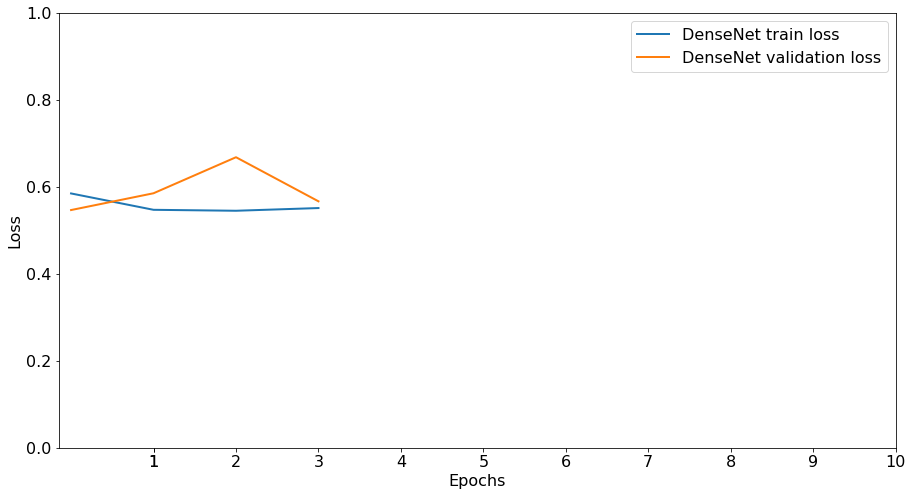

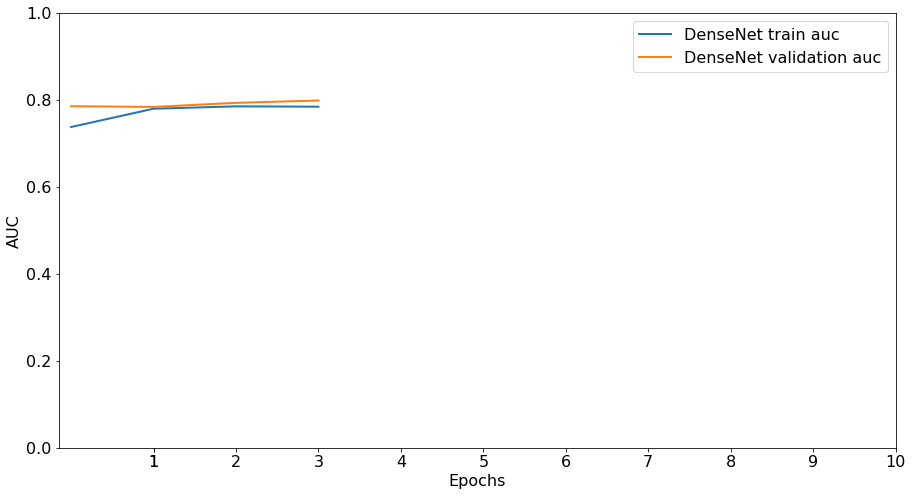

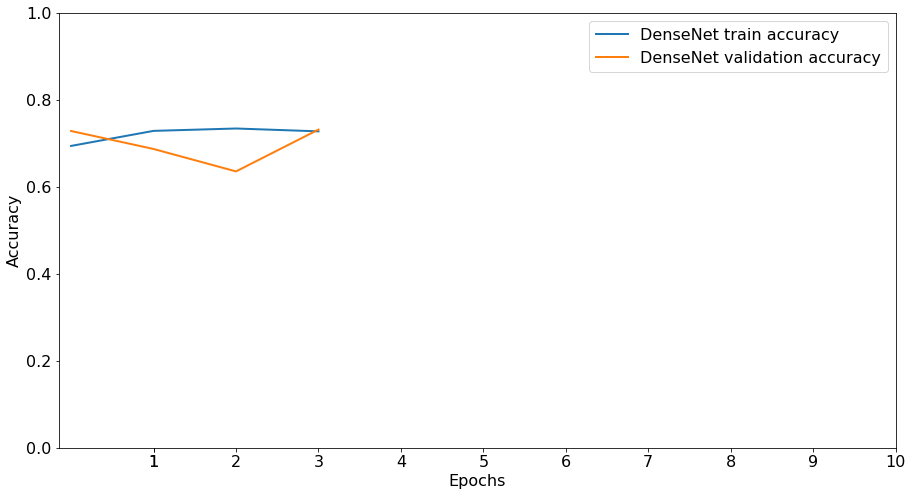

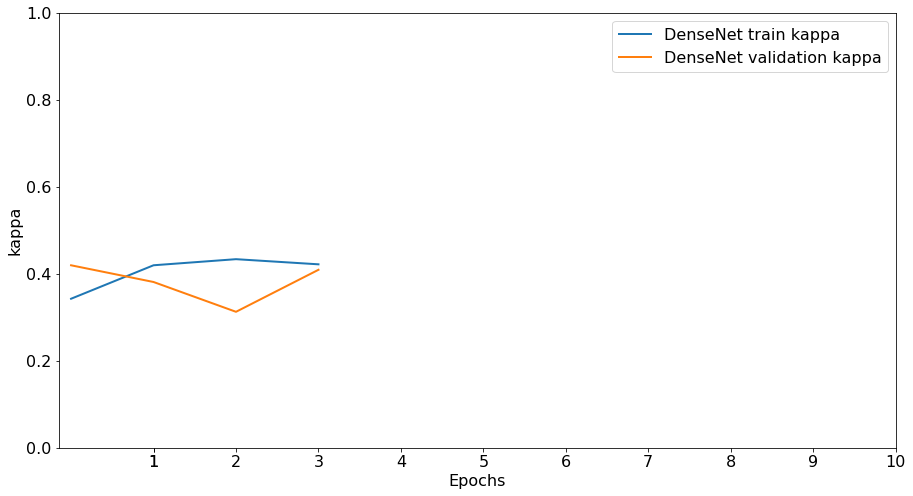

In [ ]:
print_results(model_name='DenseNet',
                  epochs= epochs,
                  hs = hs,
                  model_eval = densenet_model_eval)

#### (model_8) DenseNet

In [ ]:
epochs = 30

early_stop = EarlyStopping(monitor="kappa",#"val_loss", 
                           mode="min", 
                           patience=5, 
                           restore_best_weights=True)

densenet_model = densenet_builder(
                            pooling='max',
                            trainable_layers_after=600,
                            mlp=[512, 512],
                            mlp_dropout=0.2)

############ Compile Model ############
    
densenet_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])

############ Fit Model ################
hs = densenet_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop]
    )
    
print('Finished training.')
    
print('------------------')
densenet_model.summary() # Print a description of the model.

74842112/74836368 [==============================] - 1s 0us/step
Epoch 1/30
461/461 [==============================] - ETA: 0s - loss: 0.6009 - auc: 0.7698 - accuracy: 0.7349 - kappa: 0.4287

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


461/461 [==============================] - 256s 519ms/step - loss: 0.6009 - auc: 0.7698 - accuracy: 0.7349 - kappa: 0.4287 - val_loss: 0.4912 - val_auc: 0.8352 - val_accuracy: 0.7691 - val_kappa: 0.4951
Epoch 2/30
461/461 [==============================] - 234s 506ms/step - loss: 0.4773 - auc: 0.8365 - accuracy: 0.7849 - kappa: 0.5369 - val_loss: 0.4755 - val_auc: 0.8477 - val_accuracy: 0.7874 - val_kappa: 0.5538
Epoch 3/30
461/461 [==============================] - 234s 506ms/step - loss: 0.4353 - auc: 0.8655 - accuracy: 0.8093 - kappa: 0.5913 - val_loss: 0.4664 - val_auc: 0.8480 - val_accuracy: 0.7901 - val_kappa: 0.5492
Epoch 4/30
461/461 [==============================] - 234s 506ms/step - loss: 0.4048 - auc: 0.8851 - accuracy: 0.8240 - kappa: 0.6241 - val_loss: 0.4638 - val_auc: 0.8528 - val_accuracy: 0.7941 - val_kappa: 0.5556
Epoch 5/30
461/461 [==============================] - 233s 506ms/step - loss: 0.3662 - auc: 0.9067 - accuracy: 0.8430 - kappa: 0.6652 - val_loss: 0.4642 - 

In [ ]:
# save model
filename = 'models/model_8.h5'
densenet_model.save(filename)
print('>Saved %s' % filename)

# Evaluate on test data and show all the results.
densenet_model_eval = densenet_model.evaluate(test_generator)
clean_up(model=densenet_model)

>Saved models/model_8.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


50/50 [==============================] - 23s 450ms/step - loss: 0.5114 - auc: 0.8408 - accuracy: 0.7516 - kappa: 0.4944
...Finished clean up...


Train Loss     : 0.32865
Validation Loss: 0.48290
Test Loss      : 0.51143
---
Train AUC     : 0.92536
Validation AUC: 0.84232
Test AUC      : 0.84083
---
Train Accuracy     : 0.86294
Validation Accuracy: 0.78457
Test Accuracy      : 0.75164
---
Train Kappa     : 0.70922
Validation Kappa: 0.70922
Test Kappa      : 0.49441



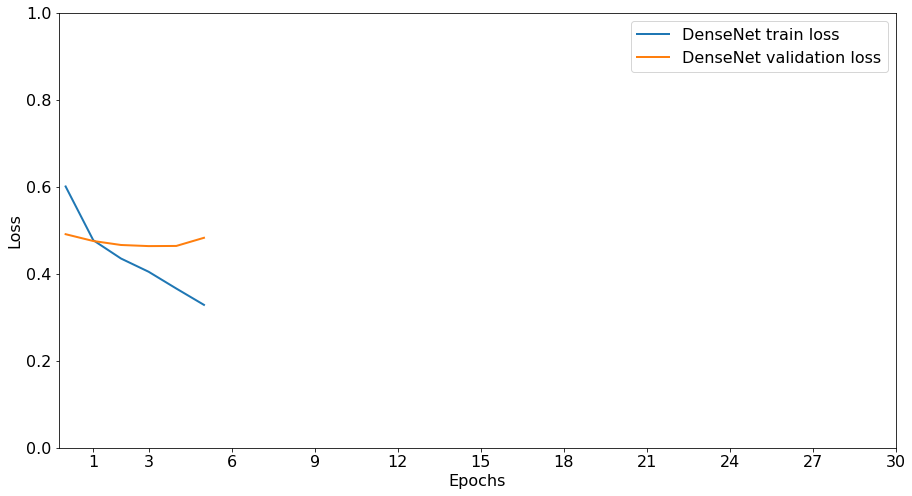

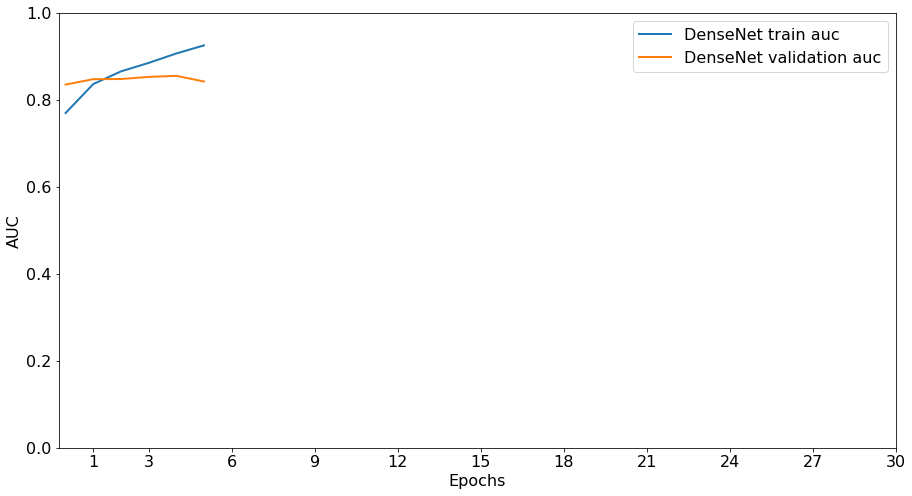

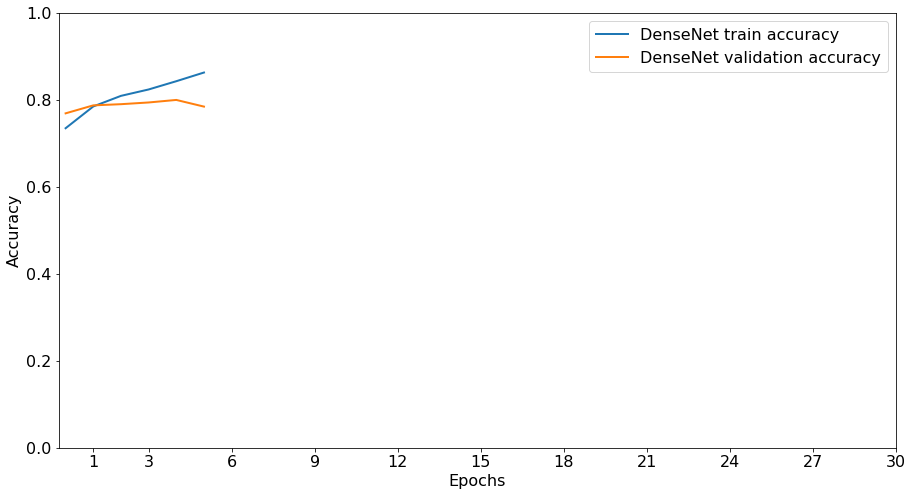

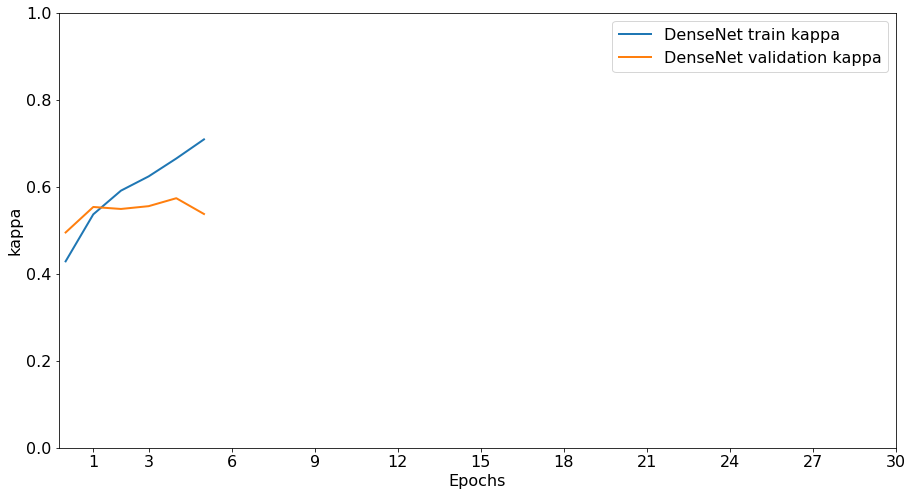

In [ ]:
print_results(model_name='DenseNet',
                  epochs= epochs,
                  hs = hs,
                  model_eval = densenet_model_eval)

#### (model_9) DenseNet

In [57]:
epochs = 30

early_stop = EarlyStopping(monitor="kappa",#"val_loss", 
                           mode="min", 
                           patience=5, 
                           restore_best_weights=True)

densenet_model = densenet_builder(
                            pooling='avg',
                            trainable_layers_after=-10,
                            mlp=[600],
                            mlp_dropout=0.2,
                            nameNN='best')

############ Compile Model ############
    
densenet_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])

############ Fit Model ################
hs = densenet_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop]
    )
    
print('Finished training.')
    
print('------------------')
densenet_model.summary() # Print a description of the model.

Epoch 1/30
461/461 [==============================] - ETA: 0s - loss: 0.5316 - auc: 0.7928 - accuracy: 0.7448 - kappa: 0.4494

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


461/461 [==============================] - 221s 457ms/step - loss: 0.5316 - auc: 0.7928 - accuracy: 0.7448 - kappa: 0.4494 - val_loss: 0.5015 - val_auc: 0.8422 - val_accuracy: 0.7611 - val_kappa: 0.4690
Epoch 2/30
461/461 [==============================] - 209s 453ms/step - loss: 0.4643 - auc: 0.8468 - accuracy: 0.7893 - kappa: 0.5477 - val_loss: 0.4664 - val_auc: 0.8508 - val_accuracy: 0.7896 - val_kappa: 0.5521
Epoch 3/30
461/461 [==============================] - 208s 450ms/step - loss: 0.4332 - auc: 0.8679 - accuracy: 0.8088 - kappa: 0.5918 - val_loss: 0.4645 - val_auc: 0.8526 - val_accuracy: 0.7946 - val_kappa: 0.5592
Epoch 4/30
461/461 [==============================] - 208s 451ms/step - loss: 0.4079 - auc: 0.8843 - accuracy: 0.8219 - kappa: 0.6211 - val_loss: 0.5168 - val_auc: 0.8530 - val_accuracy: 0.7749 - val_kappa: 0.5034
Epoch 5/30
461/461 [==============================] - 207s 449ms/step - loss: 0.3746 - auc: 0.9030 - accuracy: 0.8417 - kappa: 0.6645 - val_loss: 0.4923 - 

In [52]:
# save model
filename = 'models/model_9.h5'
densenet_model.save(filename)
print('>Saved %s' % filename)

# Evaluate on test data and show all the results.
densenet_model_eval = densenet_model.evaluate(test_generator)
clean_up(model=densenet_model)

>Saved models/model_9.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


50/50 [==============================] - 25s 495ms/step - loss: 0.5095 - auc: 0.8372 - accuracy: 0.7692 - kappa: 0.5342
...Finished clean up...


Train Loss     : 0.34175
Validation Loss: 0.53876
Test Loss      : 0.50947
---
Train AUC     : 0.92048
Validation AUC: 0.84880
Test AUC      : 0.83716
---
Train Accuracy     : 0.85492
Validation Accuracy: 0.77723
Test Accuracy      : 0.76916
---
Train Kappa     : 0.69331
Validation Kappa: 0.69331
Test Kappa      : 0.53416



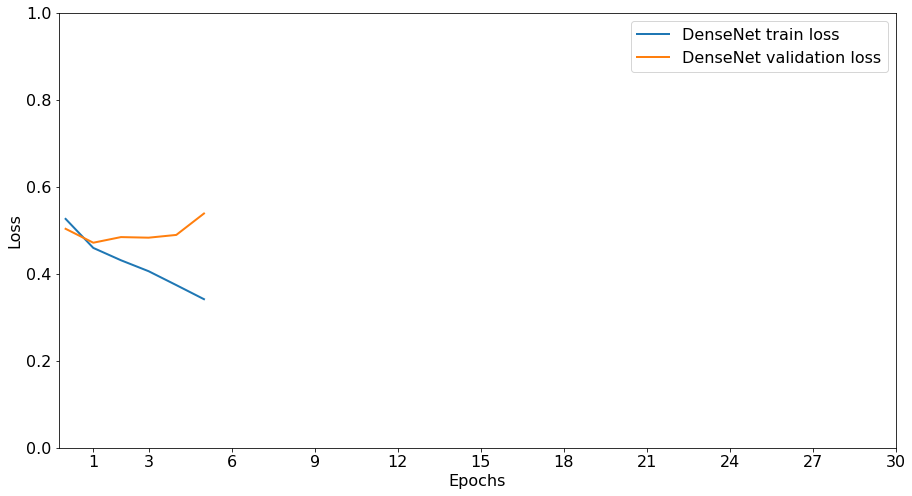

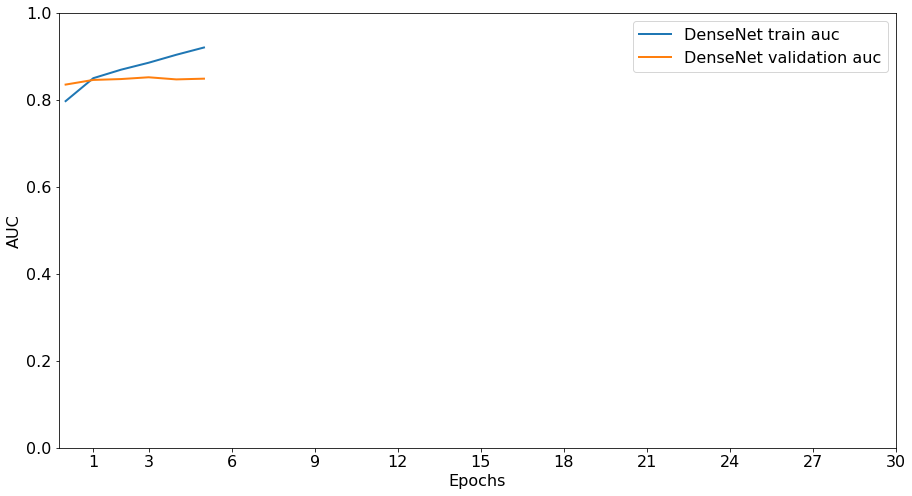

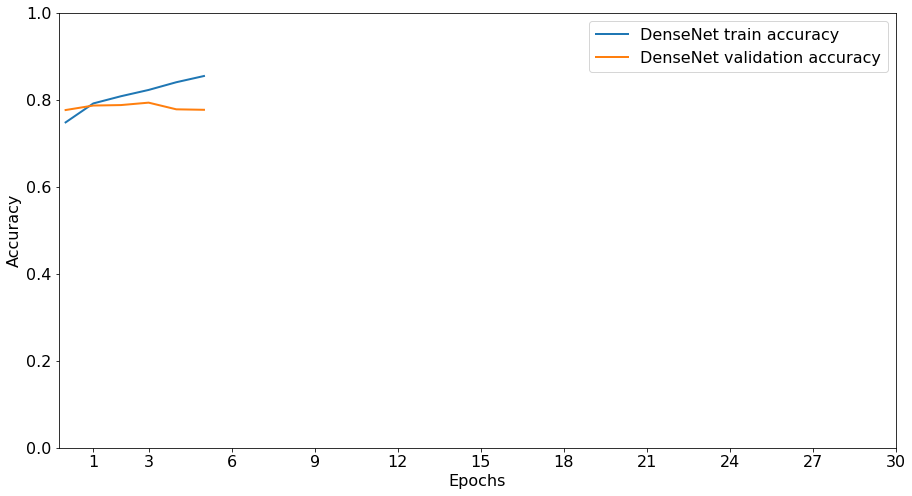

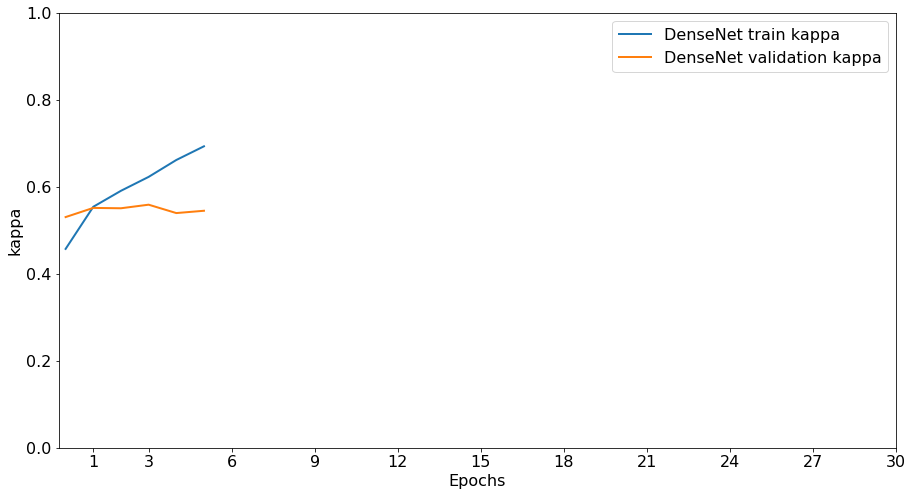

In [53]:
print_results(model_name='DenseNet',
                  epochs= epochs,
                  hs = hs,
                  model_eval = densenet_model_eval)

#### (model_10) DenseNet with augmentation

In [ ]:
image_generator_settings = dict(
                          rescale=1. / 255,
                          rotation_range=30,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          zoom_range=0.3,
                          horizontal_flip=True
                         )

image_generator = ImageDataGenerator(**image_generator_settings)

In [ ]:
train_generator = image_generator.flow_from_dataframe(
    dataframe = train,
    directory = None,
    x_col = 'image_path',
    y_col = 'label_index',
    batch_size = 64,
    shuffle = True,
    class_mode = 'raw', #"binary"
    target_size = (im_size, im_size),
    color_mode = 'rgb',#'grayscale'
    interpolation='nearest', #default
    validate_filenames=False,
    seed=seed)

Found 29446 non-validated image filenames.


In [ ]:
def densenet_builder_aug(
        pooling="avg",
        shape=(256, 256, 3),
        trainable_layers_after=None,
        mlp=[],
        mlp_dropout=0.2
):

    denseNet = DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )

    if trainable_layers_after:
        for layer in denseNet.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        denseNet.trainable = False

    output = denseNet.output

    
    for index, mlp_neurons in enumerate(mlp):
        output = Dense(mlp_neurons, activation="relu", name=f"m.{index}.{mlp_neurons}")(output)
        if mlp_dropout:
            output = Dropout(mlp_dropout, name=f"mdp.{index}.{mlp_neurons}")(output)

    output = Dense(1, activation="sigmoid", name="densenet_output_sigmoid")(output)

    model = Model(denseNet.input, output, name='densenet_aug')


    return model

In [ ]:
epochs = 15

early_stop = EarlyStopping(monitor="kappa",#"val_loss", 
                           mode="min", 
                           patience=3, 
                           restore_best_weights=True)

densenet_model = densenet_builder_aug(
                            pooling='avg',
                            trainable_layers_after=606,
                            mlp=[512, 512],
                            mlp_dropout=0.2)

############ Compile Model ############
    
densenet_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])

############ Fit Model ################
hs = densenet_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop]
    )
    
print('Finished training.')
    
print('------------------')
densenet_model.summary() # Print a description of the model.

In [ ]:
# save model
filename = 'models/model_10.h5'
densenet_model.save(filename)
print('>Saved %s' % filename)

# Evaluate on test data and show all the results.
densenet_model_eval = densenet_model.evaluate(test_generator)
clean_up(model=densenet_model)

In [ ]:
print_results(model_name='DenseNet',
                  epochs= epochs,
                  hs = hs,
                  model_eval = densenet_model_eval)

## Ensemble

Inspired by https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/

We selected n top models and we add in folder best_models, then change name from 1 to n:

model_5 -> model_1 (kappa: 0.43) [ResNet]

model_9 -> model_2 (kappa: 0.53) [DenseNet]



In [52]:
def load_all_models(n_models):

    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'best_models/model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename,custom_objects={'metrics':metrics})
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

In [53]:
# load all models
n_members = 2
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded best_models/model_1.h5
>loaded best_models/model_2.h5
Loaded 2 models


In [54]:
#https://towardsdatascience.com/ensembling-convnets-using-keras-237d429157eb
#https://medium.com/randomai/ensemble-and-store-models-in-keras-2-x-b881a6d7693f
from tensorflow.keras.layers import average

def ensembleModels(models, model_input):

    # collect outputs of models in a list
    yModels=[model(model_input) for model in models] 
    # averaging outputs
    yAvg=average(yModels) 
    # build model from same input and avg output
    modelEns = Model(inputs=model_input, outputs=yAvg, name='ensemble')  
   
    return modelEns

In [55]:
model_input = Input(shape=input_shape)
modelEns = ensembleModels(members, model_input)

In [56]:
pred_ens = modelEns.predict(test_generator)

Cohen Kappa Metric

In simple words, Cohen Kappa tells you how much better is your model over the random classifier that predicts based on class frequencies.

In [57]:
cohen_kappa_score((pred_ens> 0.5), test.label_index)

0.5551447887208136

In [58]:
accuracy_score( (pred_ens> 0.5), test.label_index)

0.7797935564591805

**Without ensembler, only with the top Densenet**

In [59]:
test_pred2 = members[1].predict(test_generator)
test_pred2 = pd.DataFrame(test_pred2)
#test_pred2

In [60]:
cohen_kappa_score((test_pred2> 0.5), test.label_index)

0.5341648679961428

In [61]:
accuracy_score( (test_pred2> 0.5), test.label_index)

0.7691585861745386

## Best model 

Ensemble with ResNet and DenseNet has the the best results(kappa: 0.55 and accurancy:0.78)

In [62]:
pred_ens = modelEns.predict(test_generator)

In [63]:
print('Kappa:',cohen_kappa_score((pred_ens> 0.5), test.label_index))

Kappa: 0.5551447887208136


In [64]:
print("Accurance:",accuracy_score( (pred_ens> 0.5), test.label_index))

Accurance: 0.7797935564591805


## Abnormal Detection by studies 


### Extract Studies

Inspired by https://github.com/ynswon/MURA

In [ ]:
test.head()

,image_path,label,category,patientId,label_index
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,11185,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,11185,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,11185,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,11185,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive,XR_WRIST,11186,1


In [ ]:
test.image_path[0]

'MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png'

In [ ]:
all_scans_df = test.copy()
all_scans_df['TrainSplit'] = all_scans_df['image_path'].map(lambda x: x.split('/')[2])
all_scans_df['FolderId'] = all_scans_df['image_path'].map(lambda x: x.split('/')[-2])
all_scans_df['Study'] = all_scans_df['FolderId'].map(lambda x: x.split('_')[0])

In [ ]:
all_scans_df_test = all_scans_df
all_scans_df_test.head()

,image_path,label,category,patientId,label_index,TrainSplit,FolderId,Study
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,11185,1,XR_WRIST,study1_positive,study1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,11185,1,XR_WRIST,study1_positive,study1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,11185,1,XR_WRIST,study1_positive,study1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,11185,1,XR_WRIST,study1_positive,study1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive,XR_WRIST,11186,1,XR_WRIST,study1_positive,study1


### Studies Mini Exploratory

In [ ]:
all_scans_df_test.Study.unique()

array(['study1', 'study2', 'study3', 'study4'], dtype=object)

In [ ]:
all_scans_df_test[all_scans_df_test.Study == 'study4']

,image_path,label,category,patientId,label_index,TrainSplit,FolderId,Study
316,MURA-v1.1/valid/XR_WRIST/patient11272/study4_n...,negative,XR_WRIST,11272,0,XR_WRIST,study4_negative,study4
317,MURA-v1.1/valid/XR_WRIST/patient11272/study4_n...,negative,XR_WRIST,11272,0,XR_WRIST,study4_negative,study4
318,MURA-v1.1/valid/XR_WRIST/patient11272/study4_n...,negative,XR_WRIST,11272,0,XR_WRIST,study4_negative,study4


In [ ]:
all_scans_df_test[(all_scans_df_test.Study == 'study3') & (all_scans_df_test.patientId == '11272') ]

,image_path,label,category,patientId,label_index,TrainSplit,FolderId,Study
313,MURA-v1.1/valid/XR_WRIST/patient11272/study3_n...,negative,XR_WRIST,11272,0,XR_WRIST,study3_negative,study3
314,MURA-v1.1/valid/XR_WRIST/patient11272/study3_n...,negative,XR_WRIST,11272,0,XR_WRIST,study3_negative,study3
315,MURA-v1.1/valid/XR_WRIST/patient11272/study3_n...,negative,XR_WRIST,11272,0,XR_WRIST,study3_negative,study3


KEimenooooooooooo

### Ensemble by studies

We selected 4 top models and we add in folder best_models, then change name from 1 to 4:

model_3 -> model_1 (kappa: 0.3) [CNN]

model_7 -> model_2 (kappa: 0.5) [DenseNet]

In [ ]:
def load_all_models(n_models):

    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'best_models/model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename,custom_objects={'metrics':metrics})
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

In [ ]:
# load all models
n_members = 2 
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded best_models/model_1.h5
>loaded best_models/model_2.h5
Loaded 2 models


In [ ]:
test_pred1 = members[0].predict(test_generator)
test_pred1 = pd.DataFrame(test_pred1)
test_pred1.head()

,0
0,0.565152
1,0.536294
2,0.499415
3,0.316998
4,0.444599


In [ ]:
test_pred2 = members[1].predict(test_generator)
test_pred2 = pd.DataFrame(test_pred2)
test_pred2.head()

,0
0,0.350203
1,0.284691
2,0.173853
3,0.175607
4,0.832444


In [ ]:
test_pred1.shape

(3197, 1)

In [ ]:
all_scans_df_test['y_pred1_probs'] = test_pred1
all_scans_df_test['y_pred2_probs'] = test_pred2

In [ ]:
all_scans_df_test.tail()

,image_path,label,category,patientId,label_index,TrainSplit,FolderId,Study,y_pred1_probs,y_pred2_probs
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,negative,XR_FINGER,11967,0,XR_FINGER,study1_negative,study1,0.008950,0.050360
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,negative,XR_FINGER,11967,0,XR_FINGER,study1_negative,study1,0.019554,0.028667
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,negative,XR_FINGER,11738,0,XR_FINGER,study1_negative,study1,0.151041,0.157743
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,negative,XR_FINGER,11738,0,XR_FINGER,study1_negative,study1,0.110425,0.202504
3196,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,negative,XR_FINGER,11738,0,XR_FINGER,study1_negative,study1,0.226663,0.156644


In [ ]:
y_pred1 = all_scans_df_test.groupby(['patientId','FolderId'])['y_pred1_probs'].mean()
y_pred2 = all_scans_df_test.groupby(['patientId','FolderId'])['y_pred2_probs'].mean()

In [ ]:
y_pred = ((y_pred1 + y_pred2)/2).round()

y_true = all_scans_df_test.groupby(['patientId','FolderId'])['label_index'].mean().round()

In [ ]:
all_scans_df_test[all_scans_df_test.patientId == '11185']

,image_path,label,category,patientId,label_index,TrainSplit,FolderId,Study,y_pred1_probs,y_pred2_probs
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,11185,1,XR_WRIST,study1_positive,study1,0.565152,0.350203
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,11185,1,XR_WRIST,study1_positive,study1,0.536294,0.284691
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,11185,1,XR_WRIST,study1_positive,study1,0.499415,0.173853
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,11185,1,XR_WRIST,study1_positive,study1,0.316998,0.175607


In [ ]:
y_pred[600:]

patientId  FolderId       
11601      study1_negative    0.0
           study1_positive    1.0
           study2_negative    1.0
11602      study1_negative    0.0
11603      study1_negative    0.0
                             ... 
11963      study1_negative    0.0
11964      study1_negative    0.0
11965      study1_negative    0.0
11966      study1_negative    0.0
11967      study1_negative    0.0
Length: 408, dtype: float32

In [ ]:
import collections
collections.Counter(y_pred)

Counter({0.0: 734, 1.0: 274})

In [ ]:
collections.Counter(y_true)

Counter({0: 539, 1: 469})

In [ ]:
from sklearn.metrics import (accuracy_score, cohen_kappa_score, f1_score, precision_score, recall_score)

In [ ]:
print("per study_type metrics:\n\taccuracy : {:.3f}\tf1 : {:.3f}\tprecision : {:.3f}\trecall : {:.3f}\tcohen_kappa : {:.3f}".format(
            accuracy_score(y_true, y_pred),
            f1_score(y_true, y_pred),
            precision_score(y_true, y_pred),
            recall_score(y_true, y_pred),
            cohen_kappa_score(y_true, y_pred), ))

per study_type metrics:
	accuracy : 0.777	f1 : 0.697	precision : 0.945	recall : 0.552	cohen_kappa : 0.539


**Without ensembler, only with the top Densenet**

In [ ]:
y_pred2 = all_scans_df_test.groupby(['patientId','FolderId'])['y_pred2_probs'].mean().round()

print("per study_type metrics:\n\taccuracy : {:.3f}\tf1 : {:.3f}\tprecision : {:.3f}\trecall : {:.3f}\tcohen_kappa : {:.3f}".format(
            accuracy_score(y_true, y_pred2),
            f1_score(y_true, y_pred2),
            precision_score(y_true, y_pred2),
            recall_score(y_true, y_pred2),
            cohen_kappa_score(y_true, y_pred2), ))

per study_type metrics:
	accuracy : 0.785	f1 : 0.710	precision : 0.950	recall : 0.567	cohen_kappa : 0.556


We can observe that the cnn decrease the metrics. So, when we want to discuss about studies, we should see only the DenseNet without basic CNN.

# Appendix

## Advance Ensembler

From Wikipedia:

Ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.

https://medium.com/@aytaj.aghabayli/ensembling-soft-hard-classifications-from-multiple-classifiers-using-the-neural-classifier-58a185a4e4d9

The architecture of a stacking model involves:
* Level-0 Models (Base-Models): Models fit on the training data and whose predictions are compiled.
* Level-1 Model (Meta-Model): Model that learns how to best combine the predictions of the base models.

https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

We selected 4 top models and we add in folder best_models, then change name from 1 to 4:

model_3 -> model_1 (kappa: 0.3) [CNN]

model_7 -> model_2 (kappa: 0.5) [DenseNet]

In [ ]:
def load_all_models(n_models):

    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'best_models/model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename,custom_objects={'metrics':metrics})
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

In [ ]:
# load all models
n_members = 2 
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded best_models/model_1.h5
>loaded best_models/model_2.h5
Loaded 2 models


In [ ]:
members[0].evaluate(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


50/50 [==============================] - 14s 274ms/step - loss: 0.6342 - auc: 0.7167 - accuracy: 0.6581 - kappa: 0.3077


[0.634185791015625, 0.7166885733604431, 0.6581169962882996, 0.3077061176300049]

In [ ]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
    stackX = None
    print("...Start stacking...")
    for model in tqdm(members):
        
        # make prediction
        yhat = model.predict(inputX, verbose=0)
            
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
            
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    print("...End stacking...")
    return stackX

In [ ]:
def fit_stacked_model(members, input):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, input)

    # fit standalone model
    print("Fit Logistic Regression")
    model = LogisticRegression()
    model.fit(stackedX, input)
    return model

In [ ]:
# fit stacked model using the ensemble
model = fit_stacked_model(members, valid_generator)


  0%|          | 0/2 [00:00<?, ?it/s]

...Start stacking...



100%|██████████| 2/2 [00:32<00:00, 16.45s/it]


...End stacking...
Fit Logistic Regression


In [ ]:
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

In [ ]:
# evaluate model on test set
yhat = stacked_prediction(members, model, test_generator)

model.evaluate(test_generator)

We did not run stacked model to the end, because Colab give a small ram. (but, we checked  that run)